## Sales Analysis with Prophet, Seasonality, Arima

In [20]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import numpy as np
import os, glob

lister = []
for f_name in ['Oct_Detail.csv','Nov_Detail.csv', 'Dec_Detail.csv', 'Jan_Detail.csv', 'Feb_Detail.csv', 'Mar_Detail.csv']:
    df = pd.read_csv('store-data/' + f_name, usecols=['RegionName','StoreName', 'BillDate', 'BillTime',
    'BillNumber', 'CustomerCode', 'CustomerName', 'ProductCode', 'Quantity', 'BillSeries', 'ProductFullName'])
    lister.append(df[~df['BillSeries'].str.contains('SR')])

salesdetail_montly = pd.concat(lister, axis=0, ignore_index=True)

salesdetail_montly

,RegionName,StoreName,BillDate,BillTime,BillNumber,CustomerCode,CustomerName,Quantity,ProductCode,BillSeries,ProductFullName
0,GUJARAT,MEDKART A MANSI,22/10/2023,1:41PM,SC20264,836526.0,kimi,2,19323,SC,LACTO CALAMINE WIPES
1,GUJARAT,MEDKART B MANJALPUR,20/10/2023,5:35PM,SC7934,835754.0,AGASTHYA,1,17595,SC,PANTOMERIT D TAB 1X10
2,GUJARAT,MEDKART B SUSEN CIRCLE,19/10/2023,5:52PM,SC14188,835317.0,RAKESH KUMAR,1,14486,SC,VILDAMERIT M 50/500MG TAB 1X10
3,GUJARAT,MEDKART B SUSEN CIRCLE,19/10/2023,5:52PM,SC14188,835317.0,RAKESH KUMAR,1,2294,SC,CHYMOMERG FORTE TAB 1X10
4,GUJARAT,DK HEALTH CARE PHARMACY,05/10/2023,6:31PM,SC5658,828779.0,PINKY VEMALI,1,13406,SC,THYRONORM 50MCG TAB 1X120
...,...,...,...,...,...,...,...,...,...,...,...
2055665,GUJARAT,MEDKART A BPCL SHASHTRINAGAR,31/03/2024,10:34PM,SC1633,479795.0,MEDKART SHASHATRINAGAR,1,6358,SC,IBUGESIC PLUS SYP 100ML
2055666,GUJARAT,MEDKART A BPCL SHASHTRINAGAR,31/03/2024,10:34PM,SC1633,479795.0,MEDKART SHASHATRINAGAR,1,6505,SC,INTAGESIC MR TAB 1X10
2055667,GUJARAT,MEDKART A BPCL SHASHTRINAGAR,31/03/2024,10:55PM,SC1634,479795.0,MEDKART SHASHATRINAGAR,1,2672,SC,COFSILS COUGH ASSRTD JAR
2055668,GUJARAT,MEDKART A BPCL SHASHTRINAGAR,31/03/2024,10:55PM,SC1634,479795.0,MEDKART SHASHATRINAGAR,1,9310,SC,NOGACID 20MG CAP 1X15


In [6]:
salesdetail_montly.columns

Index(['RegionName', 'StoreName', 'BillDate', 'BillTime', 'BillNumber',
       'CustomerCode', 'CustomerName', 'Quantity', 'ProductCode', 'BillSeries',
       'ProductFullName'],
      dtype='object')

In [7]:
salesdetail_montly.describe()

,CustomerCode,Quantity,ProductCode
count,2.340956e+06,2.341398e+06,2.341398e+06
mean,4.084024e+05,2.097520e+00,9.243024e+03
std,2.834629e+05,5.265094e+00,5.729550e+03
min,3.000000e+00,-2.200000e+02,1.000000e+00
25%,1.532690e+05,1.000000e+00,3.975000e+03
50%,3.654690e+05,1.000000e+00,9.050000e+03
75%,6.608660e+05,2.000000e+00,1.356700e+04
max,9.194050e+05,9.600000e+02,2.103900e+04


## Drop Unnecessary columns

In [8]:
salesdetail_montly.dropna(axis=1, how='all')

,RegionName,StoreName,BillDate,BillTime,BillNumber,CustomerCode,CustomerName,Quantity,ProductCode,BillSeries,ProductFullName
0,GUJARAT,MEDKART A STADIUM,01/12/2023,4:44PM,SR583,853741.0,nisha,-4,15184,SR,ZINCOMERIT TAB 1X15
1,GUJARAT,MEDKART A MANSI,22/10/2023,1:41PM,SC20264,836526.0,kimi,2,19323,SC,LACTO CALAMINE WIPES
2,GUJARAT,MEDKART B MANJALPUR,20/10/2023,5:35PM,SC7934,835754.0,AGASTHYA,1,17595,SC,PANTOMERIT D TAB 1X10
3,GUJARAT,MEDKART B SUSEN CIRCLE,19/10/2023,5:52PM,SC14188,835317.0,RAKESH KUMAR,1,14486,SC,VILDAMERIT M 50/500MG TAB 1X10
4,GUJARAT,MEDKART B SUSEN CIRCLE,19/10/2023,5:52PM,SC14188,835317.0,RAKESH KUMAR,1,2294,SC,CHYMOMERG FORTE TAB 1X10
...,...,...,...,...,...,...,...,...,...,...,...
2341393,GUJARAT,MEDKART A VEJALPUR 3,31/01/2024,9:49PM,SR217,176704.0,KAMALESH BHAI,-1,611,SR,AMOXY CLAV DS SYP 30ML
2341394,GUJARAT,MEDKART A VEJALPUR 3,31/01/2024,9:49PM,SR217,176704.0,KAMALESH BHAI,-1,2427,SR,CITICAD 10MG TAB 1X10
2341395,GUJARAT,MEDKART AN MOHINI CORNER,31/01/2024,2:59PM,SR7,880834.0,KALU,-1,1344,SR,BENALGIS TAB 1X10
2341396,GUJARAT,MEDKART AN MOHINI CORNER,31/01/2024,2:59PM,SR7,880834.0,KALU,-1,7993,SR,MEGANEURON OD PLUS CAP 1X10


In [21]:
salesdetail_montly.describe()

,CustomerCode,Quantity,ProductCode
count,2.055320e+06,2.055670e+06,2.055670e+06
mean,4.067895e+05,2.146902e+00,9.221019e+03
std,2.820293e+05,5.176856e+00,5.722235e+03
min,3.000000e+00,0.000000e+00,1.000000e+00
25%,1.525270e+05,1.000000e+00,3.927000e+03
50%,3.647470e+05,1.000000e+00,9.050000e+03
75%,6.592580e+05,2.000000e+00,1.356500e+04
max,9.101340e+05,9.600000e+02,2.052700e+04


## Customer Data Preparation

In [22]:
CustomerProductPurchase = {}
for group_name, group_data in salesdetail_montly.groupby(['RegionName', 'StoreName']):
    for group_customer, customer_data in group_data.groupby(['CustomerCode']):
        customers_data = []
        for billNumber, customer_purchases in customer_data.groupby('BillNumber'):
            for product_code, customer_purchase in customer_purchases.groupby(['ProductCode']):
              # same product is packed more than one time
                if len(customer_purchase) > 1:
                    for index in range(len(customer_purchase)-1,1):
                        customer_purchase[0]['Quantity'] = str(int(customer_purchase[0]['Quantity']) + int(customer_purchase[index]['Quantity']))

                customers_data.append(customer_purchase.iloc[0])
        CustomerProductPurchase[group_customer[0]] = pd.concat(customers_data, axis=1, ignore_index=True).transpose()

In [17]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

def FuncRunModel(func):
    for customer_code in CustomerProductPurchase:
        for product_code, product_purchase in CustomerProductPurchase[customer_code].groupby('ProductCode'):
            # select product greater than 2
            if len(product_purchase) < 2:
                continue
            display(product_purchase)
            product_purchase['bill_datetime'] = pd.to_datetime(product_purchase['BillDate'] + " " + product_purchase['BillTime'], format='%d/%m/%Y %H:%M%p')
            # getting ready for model
            product_purchase.rename(columns={'bill_datetime': 'ds', 'Quantity': 'y'}, inplace=True)
            func(product_purchase)

## Prophet Model

In [ ]:
def ProphetModel(product_purchase):
        # Create a Prophet model
        model = Prophet()

        # Fit the model to your data
        model.fit(product_purchase)

        # Generate future dates for forecasting
        future_dates = model.make_future_dataframe(periods=30)  # Adjust 'periods' as needed

        # Make forecasts for the future dates
        forecast = model.predict(future_dates)
        next_purchase_date = forecast.loc[forecast['ds'] == forecast['ds'].max(), 'ds'].values[0]
        print(next_purchase_date)
        # Plot the forecasted values
        fig = model.plot(forecast)
        plt.xlabel('Date')
        plt.ylabel('Quantity Sold')
        plt.title('Forecasted Quantity Sold')
        plt.show()

FuncRunModel(ProphetModel)

## Seasonality Model

,RegionName,StoreName,BillDate,BillTime,BillNumber,CustomerCode,CustomerName,Quantity,ProductCode,BillSeries,ProductFullName
16,GUJARAT,A-ONE MEDICOS,15/12/2023,2:07PM,SC6653,5768.0,ADITYA BHATIA VIRAT,10,1267,SC,BANDAID REGULAR
25,GUJARAT,A-ONE MEDICOS,22/12/2023,1:39PM,SC6899,5768.0,ADITYA BHATIA VIRAT,5,1267,SC,BANDAID REGULAR
35,GUJARAT,A-ONE MEDICOS,10/01/2024,6:33PM,SC7643,5768.0,ADITYA BHATIA VIRAT,5,1267,SC,BANDAID REGULAR


17:36:21 - cmdstanpy - INFO - Chain [1] start processing
17:36:22 - cmdstanpy - INFO - Chain [1] done processing


Predicted Next Date: 2024-02-09 06:33:00


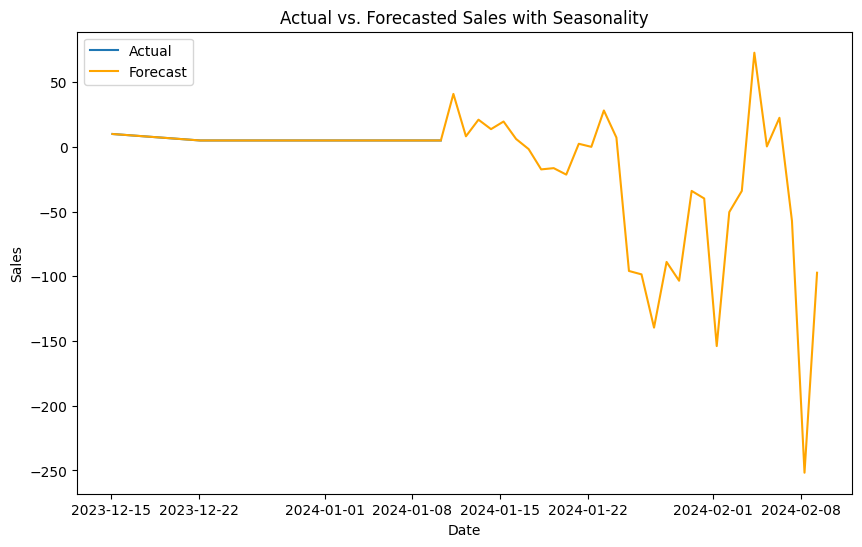

,RegionName,StoreName,BillDate,BillTime,BillNumber,CustomerCode,CustomerName,Quantity,ProductCode,BillSeries,ProductFullName
42,GUJARAT,A-ONE MEDICOS,07/02/2024,7:43PM,SC8582,5768.0,ADITYA BHATIA VIRAT,3,2672,SC,COFSILS COUGH ASSRTD JAR
43,GUJARAT,A-ONE MEDICOS,13/02/2024,6:53PM,SC8816,5768.0,ADITYA BHATIA VIRAT,10,2672,SC,COFSILS COUGH ASSRTD JAR
44,GUJARAT,A-ONE MEDICOS,13/02/2024,7:10PM,SC8819,5768.0,ADITYA BHATIA VIRAT,10,2672,SC,COFSILS COUGH ASSRTD JAR
45,GUJARAT,A-ONE MEDICOS,19/02/2024,6:19PM,SC9031,5768.0,ADITYA BHATIA VIRAT,10,2672,SC,COFSILS COUGH ASSRTD JAR


17:36:22 - cmdstanpy - INFO - Chain [1] start processing
17:36:23 - cmdstanpy - INFO - Chain [1] done processing


Predicted Next Date: 2024-03-20 06:19:00


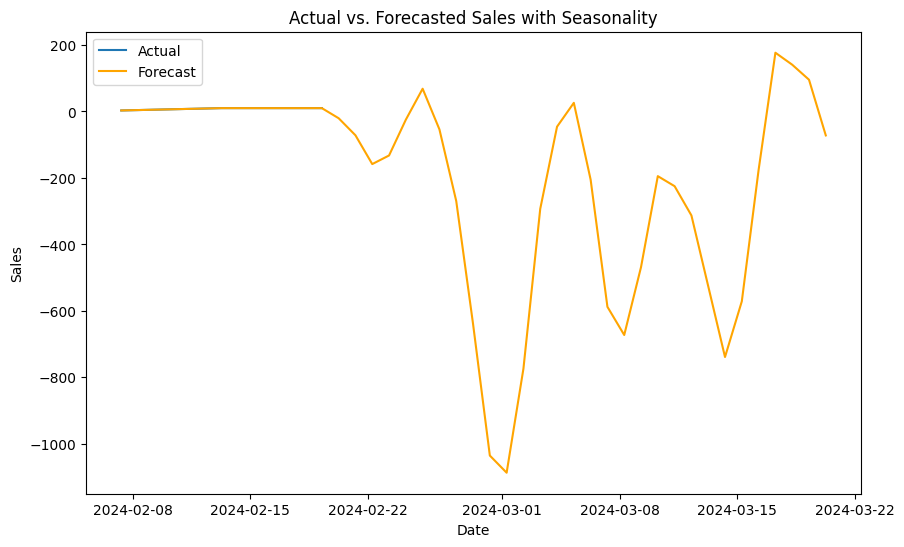

,RegionName,StoreName,BillDate,BillTime,BillNumber,CustomerCode,CustomerName,Quantity,ProductCode,BillSeries,ProductFullName
4,GUJARAT,A-ONE MEDICOS,23/10/2023,10:55PM,SC5198,5768.0,ADITYA BHATIA,1,3464,SC,DIGENE MINT TAB 1X15
28,GUJARAT,A-ONE MEDICOS,29/12/2023,11:05PM,SC7199,5768.0,ADITYA BHATIA VIRAT,1,3464,SC,DIGENE MINT TAB 1X15


Predicted Next Date: 2024-01-28 11:05:00


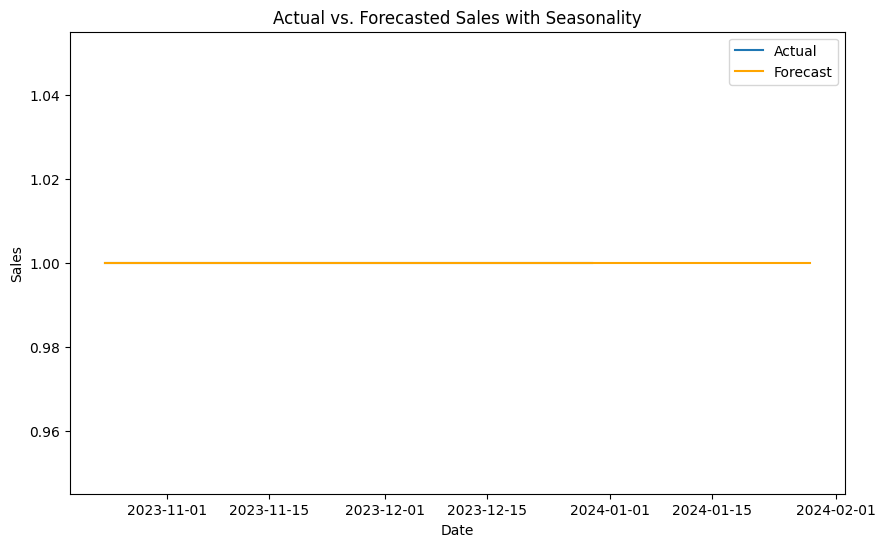

,RegionName,StoreName,BillDate,BillTime,BillNumber,CustomerCode,CustomerName,Quantity,ProductCode,BillSeries,ProductFullName
0,GUJARAT,A-ONE MEDICOS,23/03/2024,1:34PM,SC10239,5768.0,ADITYA BHATIA VIRAT,1,3606,SC,DOLO 650MG TAB 1X15
15,GUJARAT,A-ONE MEDICOS,14/12/2023,9:54AM,SC6613,5768.0,ADITYA BHATIA VIRAT,1,3606,SC,DOLO 650MG TAB 1X15
21,GUJARAT,A-ONE MEDICOS,16/12/2023,6:50PM,SC6700,5768.0,ADITYA BHATIA VIRAT,1,3606,SC,DOLO 650MG TAB 1X15
41,GUJARAT,A-ONE MEDICOS,02/02/2024,7:39PM,SC8383,5768.0,ADITYA BHATIA VIRAT,1,3606,SC,DOLO 650MG TAB 1X15


Predicted Next Date: 2024-04-22 01:34:00


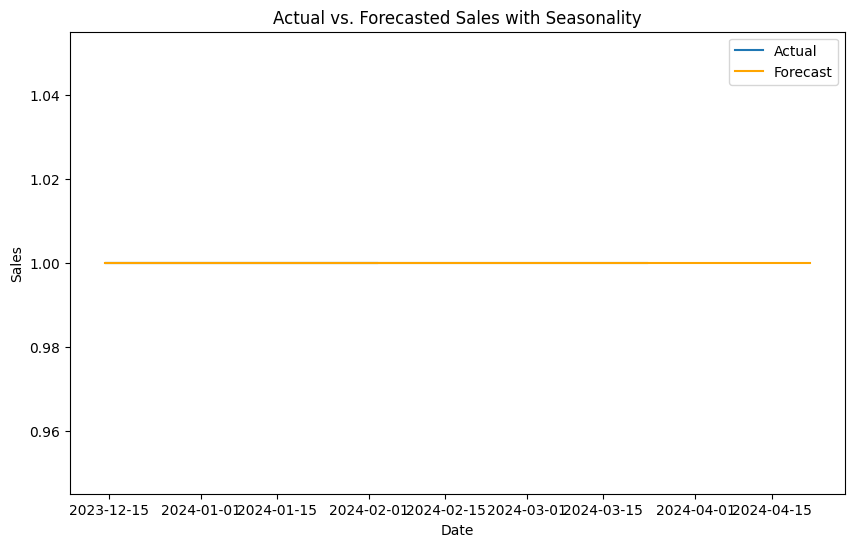

,RegionName,StoreName,BillDate,BillTime,BillNumber,CustomerCode,CustomerName,Quantity,ProductCode,BillSeries,ProductFullName
10,GUJARAT,A-ONE MEDICOS,07/12/2023,7:53PM,SC6400,5768.0,ADITYA BHATIA VIRAT,4,3920,SC,ECOSPRIN 75MG TAB 1X14
32,GUJARAT,A-ONE MEDICOS,08/01/2024,12:51PM,SC7544,5768.0,ADITYA BHATIA VIRAT,3,3920,SC,ECOSPRIN 75MG TAB 1X14
37,GUJARAT,A-ONE MEDICOS,02/02/2024,1:51PM,SC8367,5768.0,ADITYA BHATIA VIRAT,2,3920,SC,ECOSPRIN 75MG TAB 1X14
48,GUJARAT,A-ONE MEDICOS,15/03/2024,3:52PM,SC9963,5768.0,ADITYA BHATIA VIRAT,2,3920,SC,ECOSPRIN 75MG TAB 1X14


17:36:24 - cmdstanpy - INFO - Chain [1] start processing
17:36:24 - cmdstanpy - INFO - Chain [1] done processing


Predicted Next Date: 2024-04-14 03:52:00


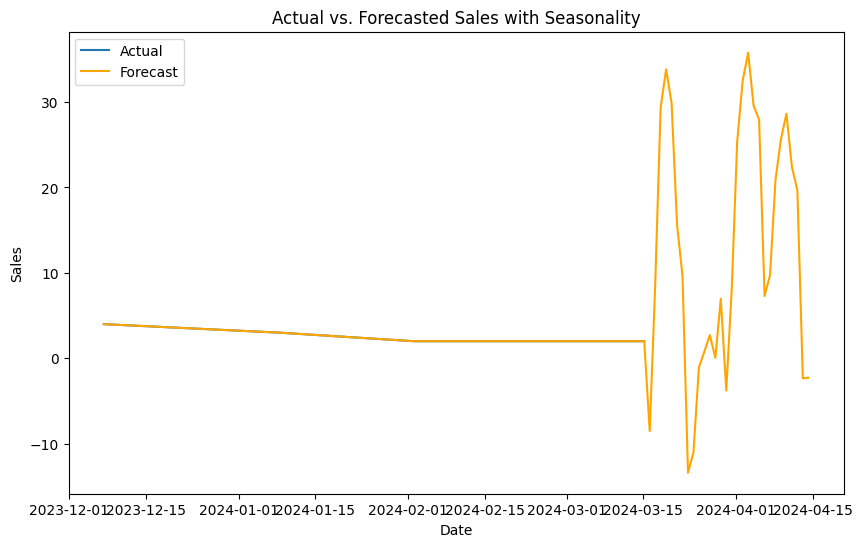

,RegionName,StoreName,BillDate,BillTime,BillNumber,CustomerCode,CustomerName,Quantity,ProductCode,BillSeries,ProductFullName
5,GUJARAT,A-ONE MEDICOS,23/10/2023,10:55PM,SC5198,5768.0,ADITYA BHATIA,1,6733,SC,KUSHAL KANTHIL 5GM TAB 1X100
8,GUJARAT,A-ONE MEDICOS,01/12/2023,9:09AM,SC6169,5768.0,ADITYA BHATIA VIRAT,1,6733,SC,KUSHAL KANTHIL 5GM TAB 1X100
14,GUJARAT,A-ONE MEDICOS,12/12/2023,9:10AM,SC6534,5768.0,ADITYA BHATIA VIRAT,1,6733,SC,KUSHAL KANTHIL 5GM TAB 1X100
26,GUJARAT,A-ONE MEDICOS,28/12/2023,5:51PM,SC7117,5768.0,ADITYA BHATIA VIRAT,1,6733,SC,KUSHAL KANTHIL 5GM TAB 1X100
36,GUJARAT,A-ONE MEDICOS,16/01/2024,3:04PM,SC7849,5768.0,ADITYA BHATIA VIRAT,1,6733,SC,KUSHAL KANTHIL 5GM TAB 1X100


Predicted Next Date: 2024-02-15 03:04:00


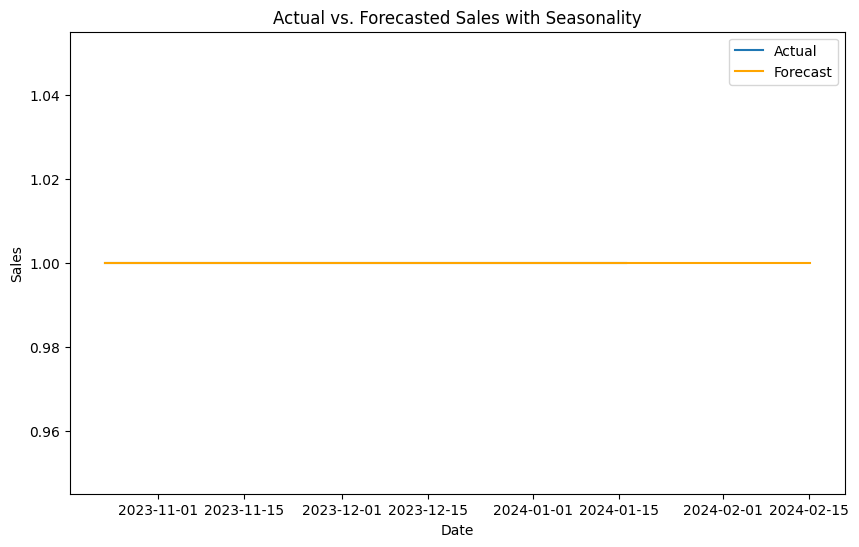

,RegionName,StoreName,BillDate,BillTime,BillNumber,CustomerCode,CustomerName,Quantity,ProductCode,BillSeries,ProductFullName
2,GUJARAT,A-ONE MEDICOS,14/10/2023,11:20AM,SC4987,5768.0,ADITYA BHATIA,2,13067,SC,TELMIRIDE AMH TAB 1X10
7,GUJARAT,A-ONE MEDICOS,26/10/2023,4:42PM,SC5250,5768.0,ADITYA BHATIA VIRAT,2,13067,SC,TELMIRIDE AMH TAB 1X10
11,GUJARAT,A-ONE MEDICOS,07/12/2023,7:53PM,SC6400,5768.0,ADITYA BHATIA VIRAT,3,13067,SC,TELMIRIDE AMH TAB 1X10
33,GUJARAT,A-ONE MEDICOS,08/01/2024,12:51PM,SC7544,5768.0,ADITYA BHATIA VIRAT,3,13067,SC,TELMIRIDE AMH TAB 1X10
38,GUJARAT,A-ONE MEDICOS,02/02/2024,1:51PM,SC8367,5768.0,ADITYA BHATIA VIRAT,4,13067,SC,TELMIRIDE AMH TAB 1X10
49,GUJARAT,A-ONE MEDICOS,15/03/2024,3:52PM,SC9963,5768.0,ADITYA BHATIA VIRAT,2,13067,SC,TELMIRIDE AMH TAB 1X10


17:36:25 - cmdstanpy - INFO - Chain [1] start processing
17:36:26 - cmdstanpy - INFO - Chain [1] done processing


Predicted Next Date: 2024-04-14 03:52:00


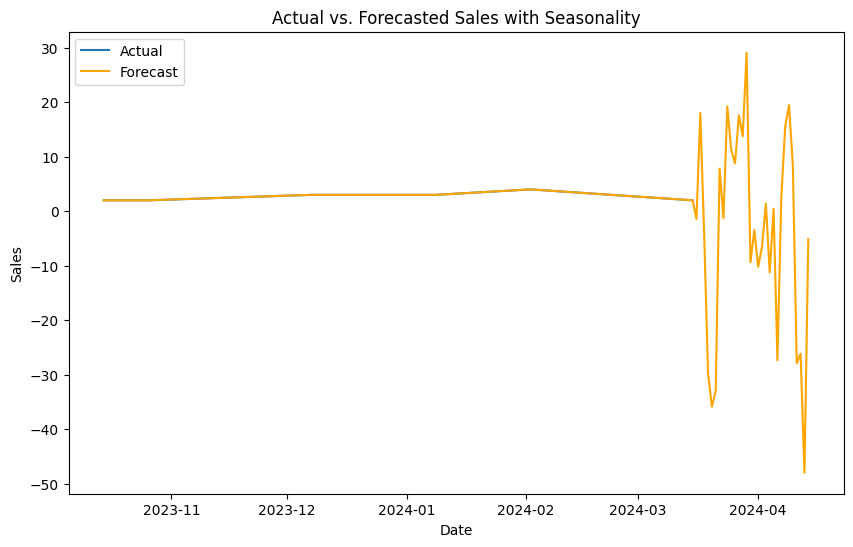

,RegionName,StoreName,BillDate,BillTime,BillNumber,CustomerCode,CustomerName,Quantity,ProductCode,BillSeries,ProductFullName
3,GUJARAT,A-ONE MEDICOS,14/10/2023,11:20AM,SC4987,5768.0,ADITYA BHATIA,2,13073,SC,TELMIRIDE MT 50MG TAB 1X10
12,GUJARAT,A-ONE MEDICOS,07/12/2023,7:53PM,SC6400,5768.0,ADITYA BHATIA VIRAT,3,13073,SC,TELMIRIDE MT 50MG TAB 1X10
34,GUJARAT,A-ONE MEDICOS,08/01/2024,12:51PM,SC7544,5768.0,ADITYA BHATIA VIRAT,1,13073,SC,TELMIRIDE MT 50MG TAB 1X10
39,GUJARAT,A-ONE MEDICOS,02/02/2024,1:51PM,SC8367,5768.0,ADITYA BHATIA VIRAT,4,13073,SC,TELMIRIDE MT 50MG TAB 1X10
50,GUJARAT,A-ONE MEDICOS,15/03/2024,3:52PM,SC9963,5768.0,ADITYA BHATIA VIRAT,3,13073,SC,TELMIRIDE MT 50MG TAB 1X10


17:36:26 - cmdstanpy - INFO - Chain [1] start processing
17:36:28 - cmdstanpy - INFO - Chain [1] done processing


Predicted Next Date: 2024-04-14 03:52:00


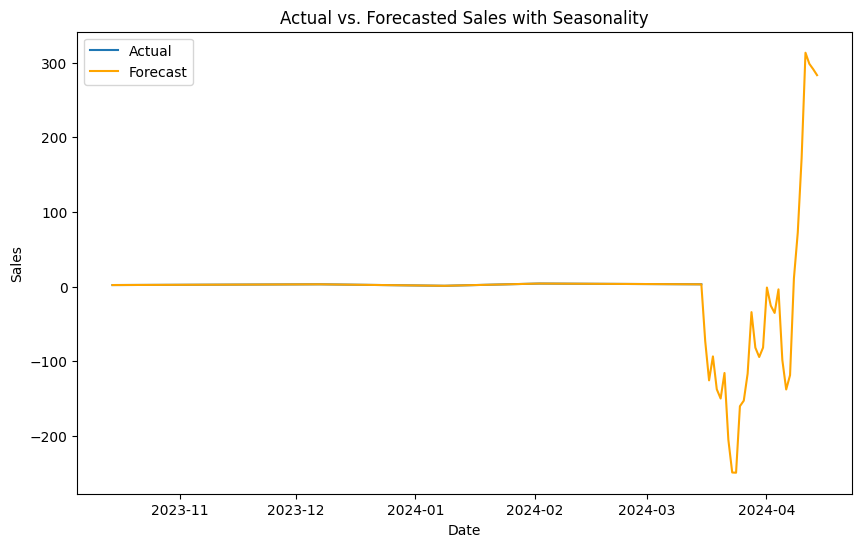

,RegionName,StoreName,BillDate,BillTime,BillNumber,CustomerCode,CustomerName,Quantity,ProductCode,BillSeries,ProductFullName
9,GUJARAT,A-ONE MEDICOS,06/12/2023,1:17PM,SC6346,5768.0,ADITYA BHATIA VIRAT,1,16900,SC,MOKCAN 500MG CAP 1X10
22,GUJARAT,A-ONE MEDICOS,16/12/2023,6:50PM,SC6700,5768.0,ADITYA BHATIA VIRAT,1,16900,SC,MOKCAN 500MG CAP 1X10


Predicted Next Date: 2024-01-15 06:50:00


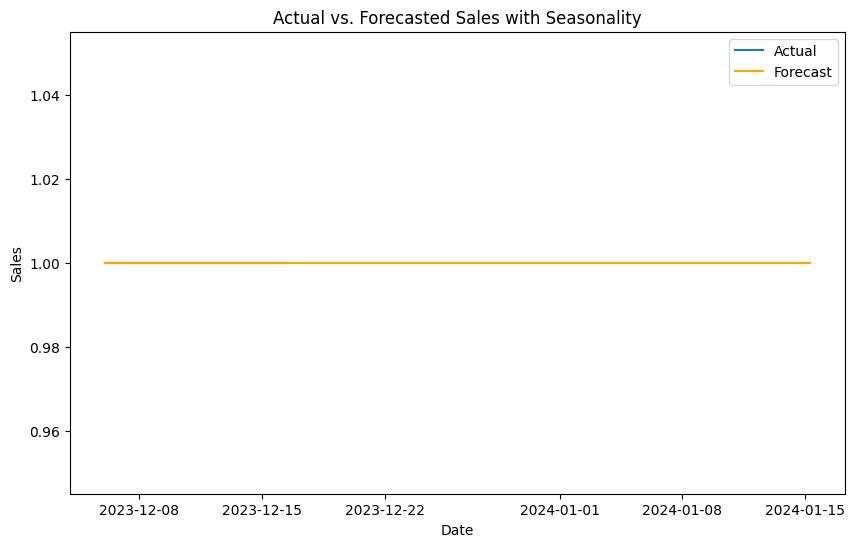

,RegionName,StoreName,BillDate,BillTime,BillNumber,CustomerCode,CustomerName,Quantity,ProductCode,BillSeries,ProductFullName
0,GUJARAT,A-ONE MEDICOS,27/03/2024,9:17PM,SC10354,5871.0,ADITYA SHARMA,3,3817,SC,DUTASMER T TAB 1X10
3,GUJARAT,A-ONE MEDICOS,16/10/2023,8:22PM,SC5023,5871.0,ADITYA SHARMA,3,3817,SC,DUTASMER T TAB 1X10
7,GUJARAT,A-ONE MEDICOS,22/11/2023,7:41PM,SC5921,5871.0,ADITYA SHARMA,3,3817,SC,DUTASMER T TAB 1X10
12,GUJARAT,A-ONE MEDICOS,13/12/2023,5:08PM,SC6589,5871.0,ADITYA SHARMA,3,3817,SC,DUTASMER T TAB 1X10
18,GUJARAT,A-ONE MEDICOS,13/01/2024,6:01PM,SC7748,5871.0,ADITYA SHARMA,3,3817,SC,DUTASMER T TAB 1X10
25,GUJARAT,A-ONE MEDICOS,22/02/2024,8:03PM,SC9173,5871.0,ADITYA SHARMA,3,3817,SC,DUTASMER T TAB 1X10


Predicted Next Date: 2024-04-26 09:17:00


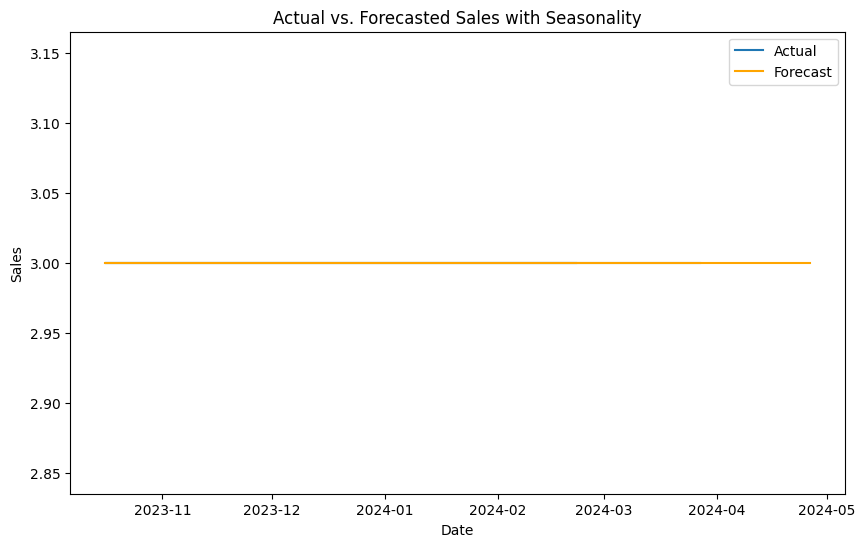

,RegionName,StoreName,BillDate,BillTime,BillNumber,CustomerCode,CustomerName,Quantity,ProductCode,BillSeries,ProductFullName
8,GUJARAT,A-ONE MEDICOS,22/11/2023,7:41PM,SC5921,5871.0,ADITYA SHARMA,1,6524,SC,IODEX RUB BOTTLE 40GM
13,GUJARAT,A-ONE MEDICOS,21/12/2023,7:24PM,SC6878,5871.0,ADITYA SHARMA,1,6524,SC,IODEX RUB BOTTLE 40GM
19,GUJARAT,A-ONE MEDICOS,13/01/2024,6:01PM,SC7748,5871.0,ADITYA SHARMA,1,6524,SC,IODEX RUB BOTTLE 40GM
20,GUJARAT,A-ONE MEDICOS,10/02/2024,7:22PM,SC8701,5871.0,ADITYA SHARMA,1,6524,SC,IODEX RUB BOTTLE 40GM


Predicted Next Date: 2024-03-11 07:22:00


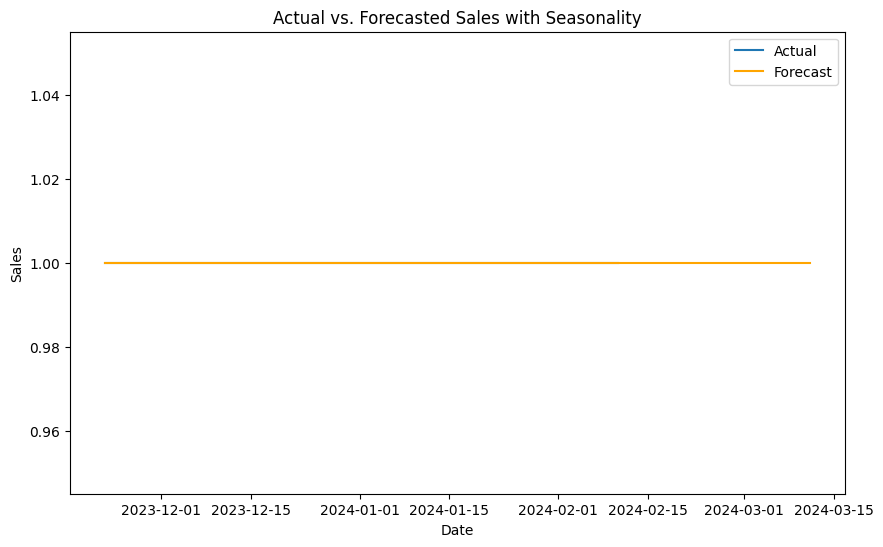

,RegionName,StoreName,BillDate,BillTime,BillNumber,CustomerCode,CustomerName,Quantity,ProductCode,BillSeries,ProductFullName
1,GUJARAT,A-ONE MEDICOS,27/03/2024,9:17PM,SC10354,5871.0,ADITYA SHARMA,9,7557,SC,LTK 25MG TAB 1X10
4,GUJARAT,A-ONE MEDICOS,25/10/2023,9:50PM,SC5237,5871.0,ADITYA SHARMA,10,7557,SC,LTK 25MG TAB 1X10
9,GUJARAT,A-ONE MEDICOS,05/12/2023,6:58PM,SC6322,5871.0,ADITYA SHARMA,1,7557,SC,LTK 25MG TAB 1X10
21,GUJARAT,A-ONE MEDICOS,10/02/2024,7:22PM,SC8701,5871.0,ADITYA SHARMA,10,7557,SC,LTK 25MG TAB 1X10


17:36:28 - cmdstanpy - INFO - Chain [1] start processing
17:36:28 - cmdstanpy - INFO - Chain [1] done processing


Predicted Next Date: 2024-04-26 09:17:00


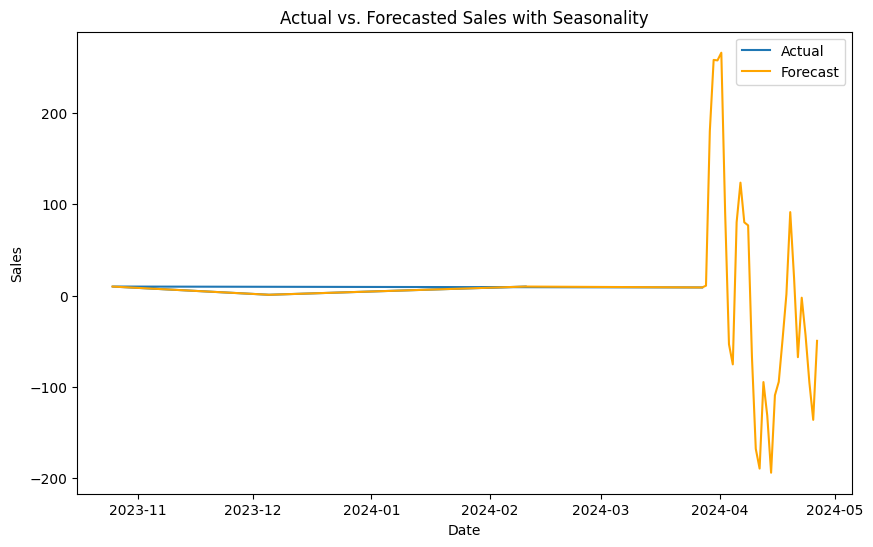

,RegionName,StoreName,BillDate,BillTime,BillNumber,CustomerCode,CustomerName,Quantity,ProductCode,BillSeries,ProductFullName
2,GUJARAT,A-ONE MEDICOS,27/03/2024,9:17PM,SC10354,5871.0,ADITYA SHARMA,3,14081,SC,UDP AT 5/50MG TAB 1X14
5,GUJARAT,A-ONE MEDICOS,25/10/2023,9:50PM,SC5237,5871.0,ADITYA SHARMA,4,14081,SC,UDP AT 5/50MG TAB 1X14
10,GUJARAT,A-ONE MEDICOS,05/12/2023,6:58PM,SC6322,5871.0,ADITYA SHARMA,4,14081,SC,UDP AT 5/50MG TAB 1X14
22,GUJARAT,A-ONE MEDICOS,10/02/2024,7:22PM,SC8701,5871.0,ADITYA SHARMA,2,14081,SC,UDP AT 5/50MG TAB 1X14


17:36:29 - cmdstanpy - INFO - Chain [1] start processing
17:36:29 - cmdstanpy - INFO - Chain [1] done processing


Predicted Next Date: 2024-04-26 09:17:00


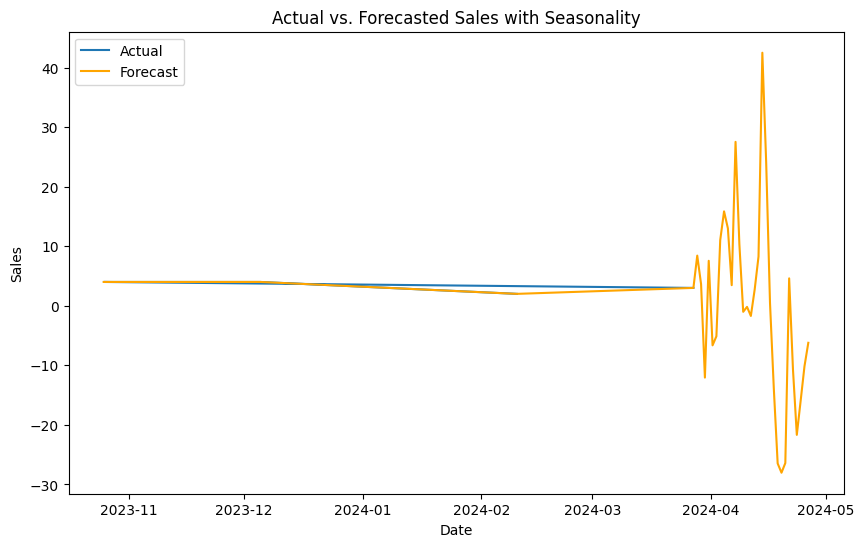

,RegionName,StoreName,BillDate,BillTime,BillNumber,CustomerCode,CustomerName,Quantity,ProductCode,BillSeries,ProductFullName
11,GUJARAT,A-ONE MEDICOS,05/12/2023,6:58PM,SC6322,5871.0,ADITYA SHARMA,1,17761,SC,EMERTONE COLD TAB 1X10
14,GUJARAT,A-ONE MEDICOS,21/12/2023,7:24PM,SC6878,5871.0,ADITYA SHARMA,1,17761,SC,EMERTONE COLD TAB 1X10
16,GUJARAT,A-ONE MEDICOS,25/12/2023,9:17PM,SC7012,5871.0,ADITYA SHARMA,1,17761,SC,EMERTONE COLD TAB 1X10
24,GUJARAT,A-ONE MEDICOS,10/02/2024,7:22PM,SC8701,5871.0,ADITYA SHARMA,1,17761,SC,EMERTONE COLD TAB 1X10


Predicted Next Date: 2024-03-11 07:22:00


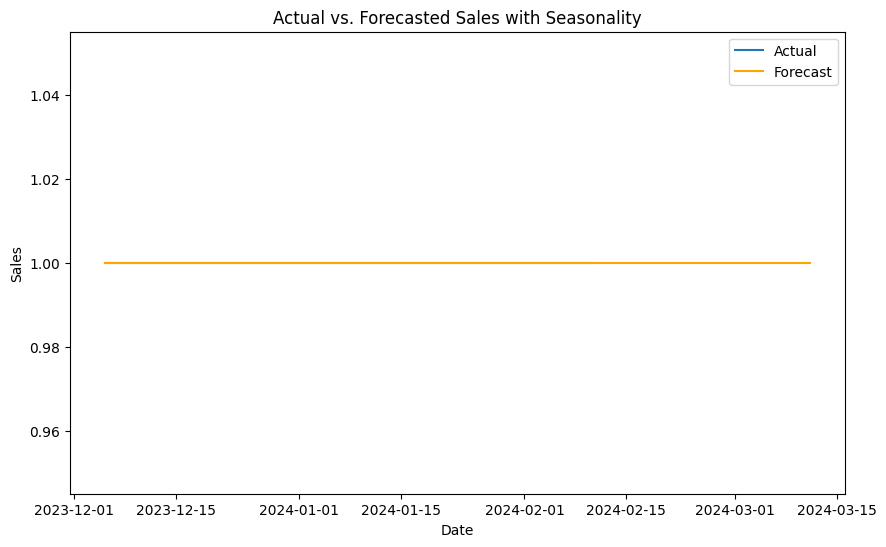

,RegionName,StoreName,BillDate,BillTime,BillNumber,CustomerCode,CustomerName,Quantity,ProductCode,BillSeries,ProductFullName
0,GUJARAT,A-ONE MEDICOS,28/10/2023,10:32AM,SC5313,5978.0,ADVOCATE R P JANWA,3,13452,SC,TIDE PLUS 10MG TAB 1X10
4,GUJARAT,A-ONE MEDICOS,12/01/2024,12:00PM,SC7701,5978.0,ADVOCATE R P JANWA,9,13452,SC,TIDE PLUS 10MG TAB 1X10


17:36:30 - cmdstanpy - INFO - Chain [1] start processing
17:36:30 - cmdstanpy - INFO - Chain [1] done processing


Predicted Next Date: 2024-02-11 12:00:00


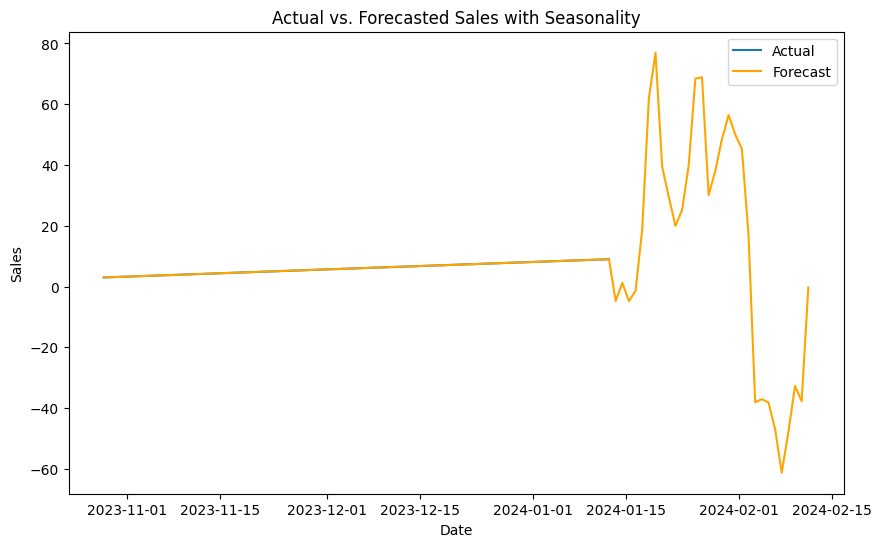

,RegionName,StoreName,BillDate,BillTime,BillNumber,CustomerCode,CustomerName,Quantity,ProductCode,BillSeries,ProductFullName
1,GUJARAT,A-ONE MEDICOS,28/10/2023,10:32AM,SC5313,5978.0,ADVOCATE R P JANWA,11,14290,SC,VALTAN 40MG TAB 1X10
5,GUJARAT,A-ONE MEDICOS,12/01/2024,12:00PM,SC7701,5978.0,ADVOCATE R P JANWA,18,14290,SC,VALTAN 40MG TAB 1X10


17:36:30 - cmdstanpy - INFO - Chain [1] start processing
17:36:30 - cmdstanpy - INFO - Chain [1] done processing


Predicted Next Date: 2024-02-11 12:00:00


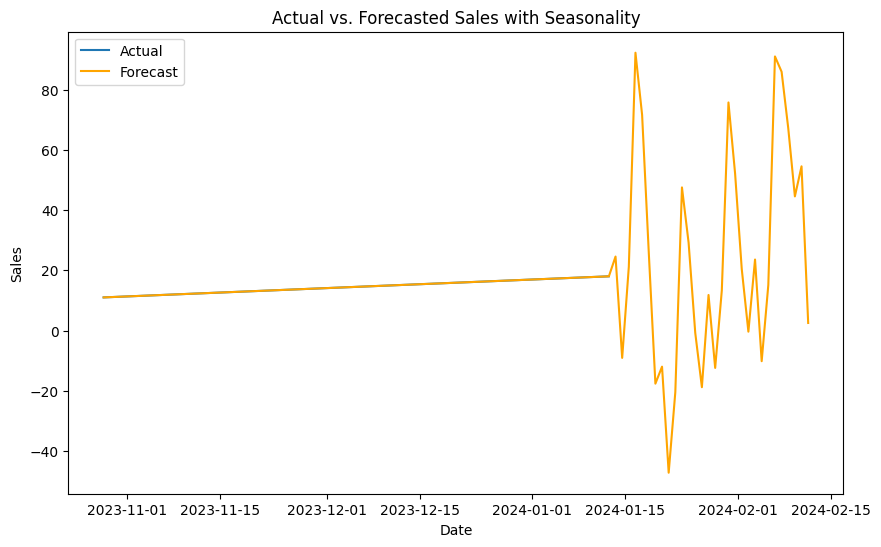

,RegionName,StoreName,BillDate,BillTime,BillNumber,CustomerCode,CustomerName,Quantity,ProductCode,BillSeries,ProductFullName
2,GUJARAT,A-ONE MEDICOS,28/10/2023,10:32AM,SC5313,5978.0,ADVOCATE R P JANWA,9,17467,SC,EMETOP XL 50MG TAB 1X10
6,GUJARAT,A-ONE MEDICOS,12/01/2024,12:00PM,SC7701,5978.0,ADVOCATE R P JANWA,9,17467,SC,EMETOP XL 50MG TAB 1X10


Predicted Next Date: 2024-02-11 12:00:00


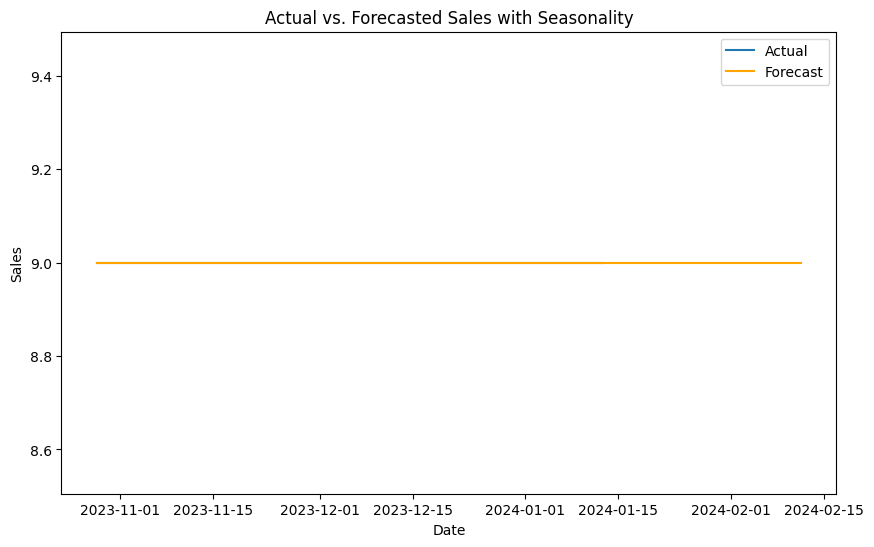

,RegionName,StoreName,BillDate,BillTime,BillNumber,CustomerCode,CustomerName,Quantity,ProductCode,BillSeries,ProductFullName
3,GUJARAT,A-ONE MEDICOS,28/10/2023,10:32AM,SC5313,5978.0,ADVOCATE R P JANWA,6,17839,SC,ATORVASTATUS ASP GOLD 10MG TAB 1X15
7,GUJARAT,A-ONE MEDICOS,12/01/2024,12:00PM,SC7701,5978.0,ADVOCATE R P JANWA,6,17839,SC,ATORVASTATUS ASP GOLD 10MG TAB 1X15


Predicted Next Date: 2024-02-11 12:00:00


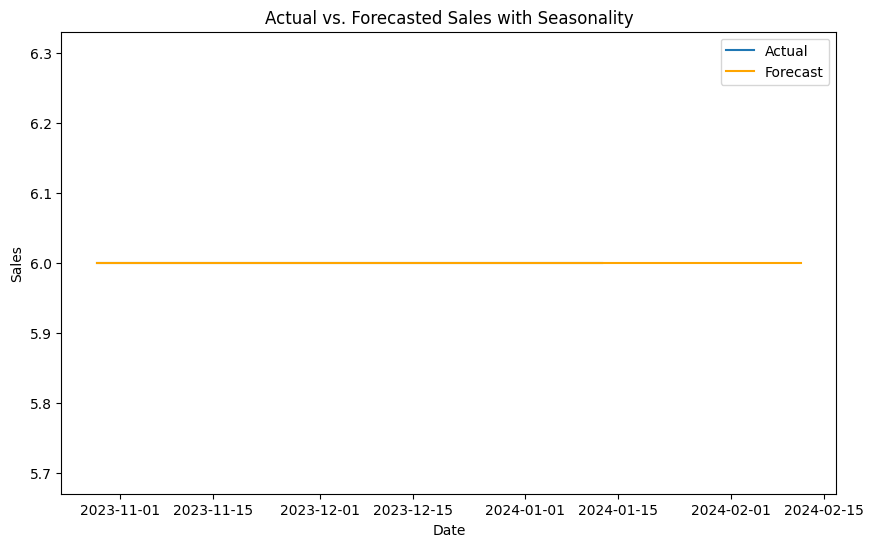

,RegionName,StoreName,BillDate,BillTime,BillNumber,CustomerCode,CustomerName,Quantity,ProductCode,BillSeries,ProductFullName
15,GUJARAT,A-ONE MEDICOS,25/11/2023,7:28PM,SC6008,7278.0,AJAY BHAI THAKKAR,1,17,SC,A MOR Z TAB 1X15
28,GUJARAT,A-ONE MEDICOS,20/12/2023,10:36PM,SC6839,7278.0,AJAY BHAI THAKKAR,1,17,SC,A MOR Z TAB 1X15
41,GUJARAT,A-ONE MEDICOS,19/01/2024,9:27PM,SC7980,7278.0,AJAY BHAI THAKKAR,1,17,SC,A MOR Z TAB 1X15
55,GUJARAT,A-ONE MEDICOS,26/02/2024,9:28PM,SC9310,7278.0,AJAY BHAI THAKKAR,1,17,SC,A MOR Z TAB 1X15


Predicted Next Date: 2024-03-27 09:28:00


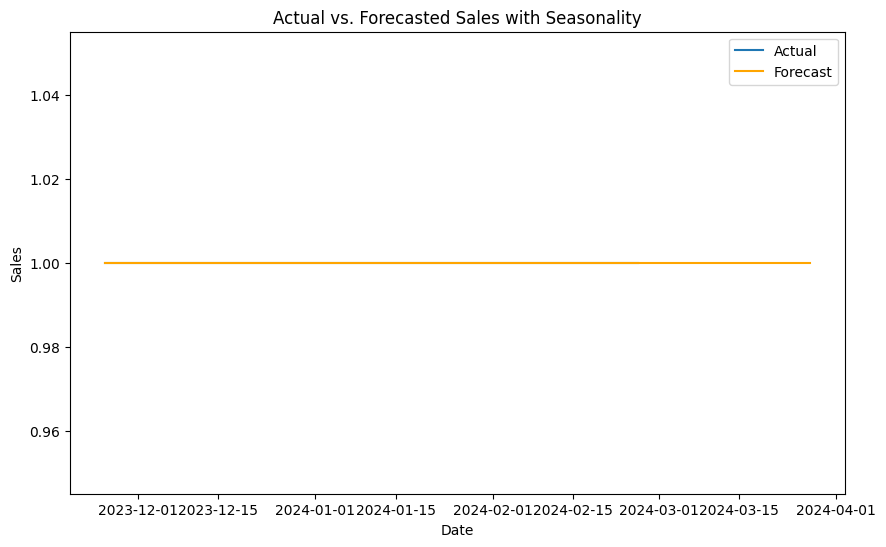

,RegionName,StoreName,BillDate,BillTime,BillNumber,CustomerCode,CustomerName,Quantity,ProductCode,BillSeries,ProductFullName
0,GUJARAT,A-ONE MEDICOS,29/03/2024,9:34PM,SC10426,7278.0,AJAY BHAI THAKKAR,4,1859,SC,CALCIGEN 500MG TAB 1X15
16,GUJARAT,A-ONE MEDICOS,25/11/2023,7:28PM,SC6008,7278.0,AJAY BHAI THAKKAR,4,1859,SC,CALCIGEN 500MG TAB 1X15
29,GUJARAT,A-ONE MEDICOS,20/12/2023,10:36PM,SC6839,7278.0,AJAY BHAI THAKKAR,4,1859,SC,CALCIGEN 500MG TAB 1X15
43,GUJARAT,A-ONE MEDICOS,19/01/2024,9:27PM,SC7980,7278.0,AJAY BHAI THAKKAR,4,1859,SC,CALCIGEN 500MG TAB 1X15
56,GUJARAT,A-ONE MEDICOS,26/02/2024,9:28PM,SC9310,7278.0,AJAY BHAI THAKKAR,1,1859,SC,CALCIGEN 500MG TAB 1X15


17:36:31 - cmdstanpy - INFO - Chain [1] start processing
17:36:32 - cmdstanpy - INFO - Chain [1] done processing


Predicted Next Date: 2024-04-28 09:34:00


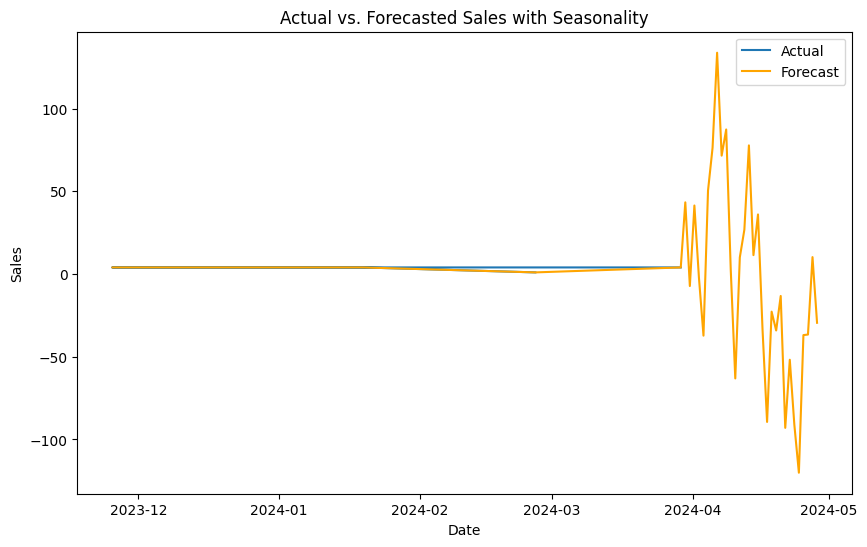

,RegionName,StoreName,BillDate,BillTime,BillNumber,CustomerCode,CustomerName,Quantity,ProductCode,BillSeries,ProductFullName
1,GUJARAT,A-ONE MEDICOS,29/03/2024,9:34PM,SC10426,7278.0,AJAY BHAI THAKKAR,3,2111,SC,CARVEDIOL CR 20MG TAB 1X10
12,GUJARAT,A-ONE MEDICOS,03/10/2023,8:16PM,SC4660,7278.0,AJAY BHAI THAKKAR,1,2111,SC,CARVEDIOL CR 20MG TAB 1X10
17,GUJARAT,A-ONE MEDICOS,25/11/2023,7:28PM,SC6008,7278.0,AJAY BHAI THAKKAR,3,2111,SC,CARVEDIOL CR 20MG TAB 1X10
30,GUJARAT,A-ONE MEDICOS,20/12/2023,10:36PM,SC6839,7278.0,AJAY BHAI THAKKAR,3,2111,SC,CARVEDIOL CR 20MG TAB 1X10
44,GUJARAT,A-ONE MEDICOS,19/01/2024,9:27PM,SC7980,7278.0,AJAY BHAI THAKKAR,3,2111,SC,CARVEDIOL CR 20MG TAB 1X10
57,GUJARAT,A-ONE MEDICOS,26/02/2024,9:28PM,SC9310,7278.0,AJAY BHAI THAKKAR,3,2111,SC,CARVEDIOL CR 20MG TAB 1X10


17:36:32 - cmdstanpy - INFO - Chain [1] start processing
17:36:35 - cmdstanpy - INFO - Chain [1] done processing


Predicted Next Date: 2024-04-28 09:34:00


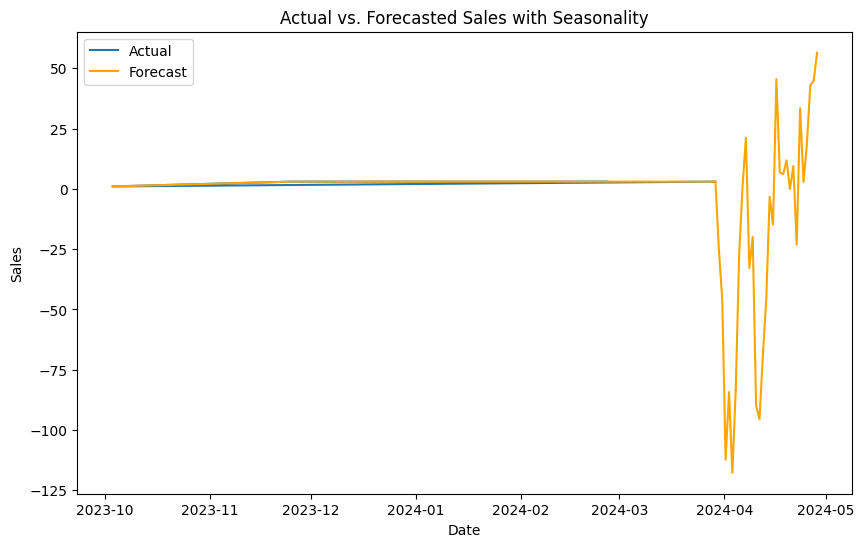

,RegionName,StoreName,BillDate,BillTime,BillNumber,CustomerCode,CustomerName,Quantity,ProductCode,BillSeries,ProductFullName
2,GUJARAT,A-ONE MEDICOS,29/03/2024,9:34PM,SC10426,7278.0,AJAY BHAI THAKKAR,3,2603,SC,CLOPIZEN 75MG TAB 1X10
18,GUJARAT,A-ONE MEDICOS,25/11/2023,7:28PM,SC6008,7278.0,AJAY BHAI THAKKAR,3,2603,SC,CLOPIZEN 75MG TAB 1X10
31,GUJARAT,A-ONE MEDICOS,20/12/2023,10:36PM,SC6839,7278.0,AJAY BHAI THAKKAR,3,2603,SC,CLOPIZEN 75MG TAB 1X10
45,GUJARAT,A-ONE MEDICOS,19/01/2024,9:27PM,SC7980,7278.0,AJAY BHAI THAKKAR,3,2603,SC,CLOPIZEN 75MG TAB 1X10
58,GUJARAT,A-ONE MEDICOS,26/02/2024,9:28PM,SC9310,7278.0,AJAY BHAI THAKKAR,3,2603,SC,CLOPIZEN 75MG TAB 1X10


Predicted Next Date: 2024-04-28 09:34:00


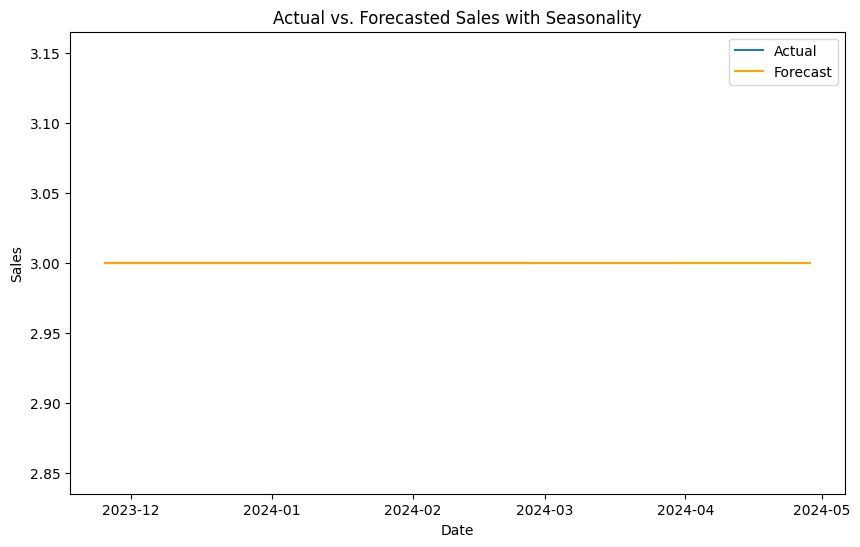

,RegionName,StoreName,BillDate,BillTime,BillNumber,CustomerCode,CustomerName,Quantity,ProductCode,BillSeries,ProductFullName
3,GUJARAT,A-ONE MEDICOS,29/03/2024,9:34PM,SC10426,7278.0,AJAY BHAI THAKKAR,3,4001,SC,ELGLUCO 500MG TAB 1X10
13,GUJARAT,A-ONE MEDICOS,03/10/2023,8:16PM,SC4660,7278.0,AJAY BHAI THAKKAR,2,4001,SC,ELGLUCO 500MG TAB 1X10
19,GUJARAT,A-ONE MEDICOS,25/11/2023,7:28PM,SC6008,7278.0,AJAY BHAI THAKKAR,3,4001,SC,ELGLUCO 500MG TAB 1X10
32,GUJARAT,A-ONE MEDICOS,20/12/2023,10:36PM,SC6839,7278.0,AJAY BHAI THAKKAR,3,4001,SC,ELGLUCO 500MG TAB 1X10
46,GUJARAT,A-ONE MEDICOS,19/01/2024,9:27PM,SC7980,7278.0,AJAY BHAI THAKKAR,3,4001,SC,ELGLUCO 500MG TAB 1X10
59,GUJARAT,A-ONE MEDICOS,26/02/2024,9:28PM,SC9310,7278.0,AJAY BHAI THAKKAR,1,4001,SC,ELGLUCO 500MG TAB 1X10


17:36:35 - cmdstanpy - INFO - Chain [1] start processing
17:36:36 - cmdstanpy - INFO - Chain [1] done processing


Predicted Next Date: 2024-04-28 09:34:00


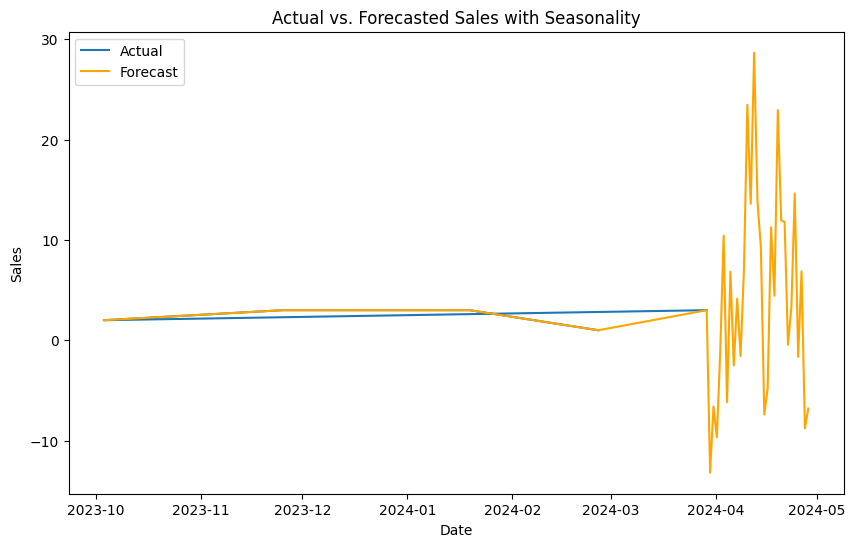

,RegionName,StoreName,BillDate,BillTime,BillNumber,CustomerCode,CustomerName,Quantity,ProductCode,BillSeries,ProductFullName
4,GUJARAT,A-ONE MEDICOS,29/03/2024,9:34PM,SC10426,7278.0,AJAY BHAI THAKKAR,3,4059,SC,EMER GM 1MG TAB 1X15
20,GUJARAT,A-ONE MEDICOS,25/11/2023,7:28PM,SC6008,7278.0,AJAY BHAI THAKKAR,4,4059,SC,EMER GM 1MG TAB 1X15
33,GUJARAT,A-ONE MEDICOS,20/12/2023,10:36PM,SC6839,7278.0,AJAY BHAI THAKKAR,4,4059,SC,EMER GM 1MG TAB 1X15
47,GUJARAT,A-ONE MEDICOS,19/01/2024,9:27PM,SC7980,7278.0,AJAY BHAI THAKKAR,4,4059,SC,EMER GM 1MG TAB 1X15
60,GUJARAT,A-ONE MEDICOS,26/02/2024,9:28PM,SC9310,7278.0,AJAY BHAI THAKKAR,4,4059,SC,EMER GM 1MG TAB 1X15


17:36:36 - cmdstanpy - INFO - Chain [1] start processing
17:36:37 - cmdstanpy - INFO - Chain [1] done processing


Predicted Next Date: 2024-04-28 09:34:00


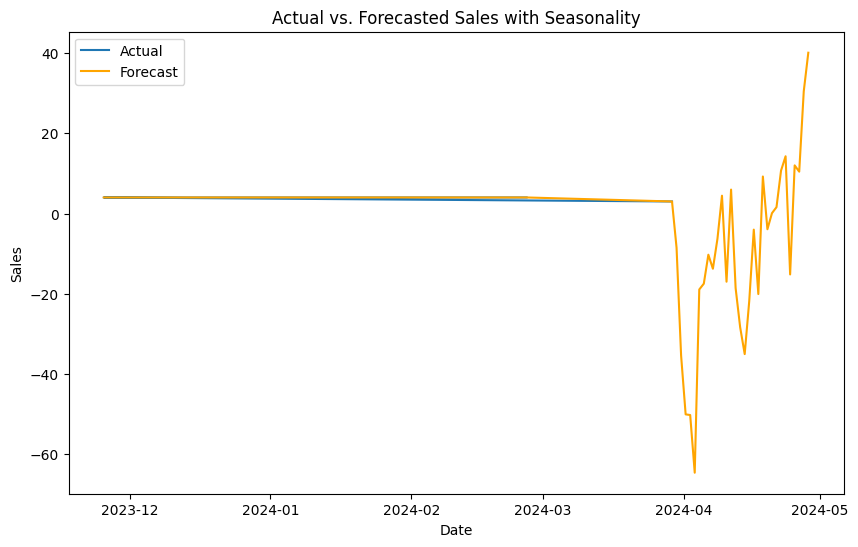

,RegionName,StoreName,BillDate,BillTime,BillNumber,CustomerCode,CustomerName,Quantity,ProductCode,BillSeries,ProductFullName
5,GUJARAT,A-ONE MEDICOS,29/03/2024,9:34PM,SC10426,7278.0,AJAY BHAI THAKKAR,3,4087,SC,EMTOR 10MG TAB 1X10
21,GUJARAT,A-ONE MEDICOS,25/11/2023,7:28PM,SC6008,7278.0,AJAY BHAI THAKKAR,3,4087,SC,EMTOR 10MG TAB 1X10
34,GUJARAT,A-ONE MEDICOS,20/12/2023,10:36PM,SC6839,7278.0,AJAY BHAI THAKKAR,1,4087,SC,EMTOR 10MG TAB 1X10
48,GUJARAT,A-ONE MEDICOS,19/01/2024,9:27PM,SC7980,7278.0,AJAY BHAI THAKKAR,3,4087,SC,EMTOR 10MG TAB 1X10
61,GUJARAT,A-ONE MEDICOS,26/02/2024,9:28PM,SC9310,7278.0,AJAY BHAI THAKKAR,3,4087,SC,EMTOR 10MG TAB 1X10


17:36:37 - cmdstanpy - INFO - Chain [1] start processing
17:36:37 - cmdstanpy - INFO - Chain [1] done processing


Predicted Next Date: 2024-04-28 09:34:00


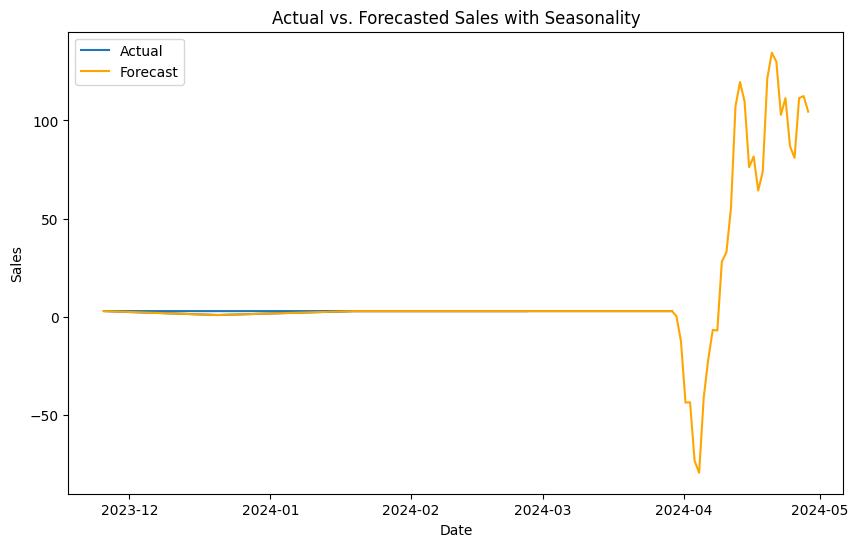

,RegionName,StoreName,BillDate,BillTime,BillNumber,CustomerCode,CustomerName,Quantity,ProductCode,BillSeries,ProductFullName
6,GUJARAT,A-ONE MEDICOS,29/03/2024,9:34PM,SC10426,7278.0,AJAY BHAI THAKKAR,1,4700,SC,FDSON 12MG TAB 1X30
22,GUJARAT,A-ONE MEDICOS,25/11/2023,7:28PM,SC6008,7278.0,AJAY BHAI THAKKAR,1,4700,SC,FDSON 12MG TAB 1X30
35,GUJARAT,A-ONE MEDICOS,20/12/2023,10:36PM,SC6839,7278.0,AJAY BHAI THAKKAR,1,4700,SC,FDSON 12MG TAB 1X30
49,GUJARAT,A-ONE MEDICOS,19/01/2024,9:27PM,SC7980,7278.0,AJAY BHAI THAKKAR,1,4700,SC,FDSON 12MG TAB 1X30
62,GUJARAT,A-ONE MEDICOS,26/02/2024,9:28PM,SC9310,7278.0,AJAY BHAI THAKKAR,1,4700,SC,FDSON 12MG TAB 1X30


Predicted Next Date: 2024-04-28 09:34:00


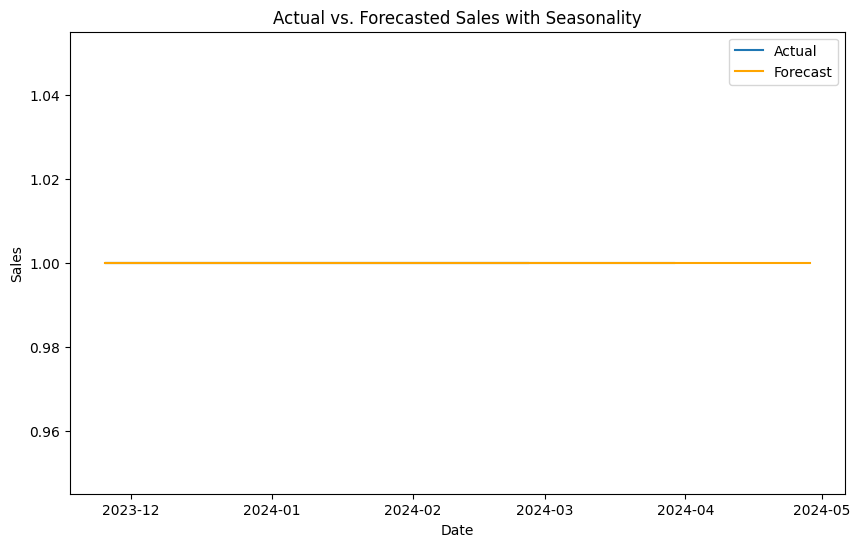

,RegionName,StoreName,BillDate,BillTime,BillNumber,CustomerCode,CustomerName,Quantity,ProductCode,BillSeries,ProductFullName
7,GUJARAT,A-ONE MEDICOS,29/03/2024,9:34PM,SC10426,7278.0,AJAY BHAI THAKKAR,3,4767,SC,FEMPRO 2.5MG TAB 1X10
23,GUJARAT,A-ONE MEDICOS,25/11/2023,7:28PM,SC6008,7278.0,AJAY BHAI THAKKAR,3,4767,SC,FEMPRO 2.5MG TAB 1X10
36,GUJARAT,A-ONE MEDICOS,20/12/2023,10:36PM,SC6839,7278.0,AJAY BHAI THAKKAR,1,4767,SC,FEMPRO 2.5MG TAB 1X10
50,GUJARAT,A-ONE MEDICOS,19/01/2024,9:27PM,SC7980,7278.0,AJAY BHAI THAKKAR,3,4767,SC,FEMPRO 2.5MG TAB 1X10
63,GUJARAT,A-ONE MEDICOS,26/02/2024,9:28PM,SC9310,7278.0,AJAY BHAI THAKKAR,2,4767,SC,FEMPRO 2.5MG TAB 1X10


17:36:37 - cmdstanpy - INFO - Chain [1] start processing
17:36:38 - cmdstanpy - INFO - Chain [1] done processing


Predicted Next Date: 2024-04-28 09:34:00


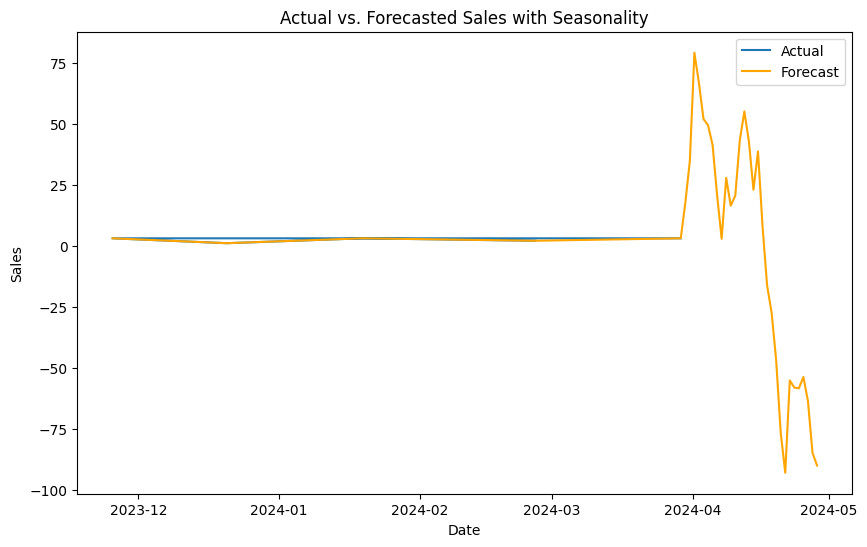

,RegionName,StoreName,BillDate,BillTime,BillNumber,CustomerCode,CustomerName,Quantity,ProductCode,BillSeries,ProductFullName
8,GUJARAT,A-ONE MEDICOS,29/03/2024,9:34PM,SC10426,7278.0,AJAY BHAI THAKKAR,3,11704,SC,ROSUVASTATUS 10MG TAB 1X10
24,GUJARAT,A-ONE MEDICOS,25/11/2023,7:28PM,SC6008,7278.0,AJAY BHAI THAKKAR,3,11704,SC,ROSUVASTATUS 10MG TAB 1X10
37,GUJARAT,A-ONE MEDICOS,20/12/2023,10:36PM,SC6839,7278.0,AJAY BHAI THAKKAR,3,11704,SC,ROSUVASTATUS 10MG TAB 1X10
51,GUJARAT,A-ONE MEDICOS,19/01/2024,9:27PM,SC7980,7278.0,AJAY BHAI THAKKAR,3,11704,SC,ROSUVASTATUS 10MG TAB 1X10
64,GUJARAT,A-ONE MEDICOS,26/02/2024,9:28PM,SC9310,7278.0,AJAY BHAI THAKKAR,3,11704,SC,ROSUVASTATUS 10MG TAB 1X10


Predicted Next Date: 2024-04-28 09:34:00


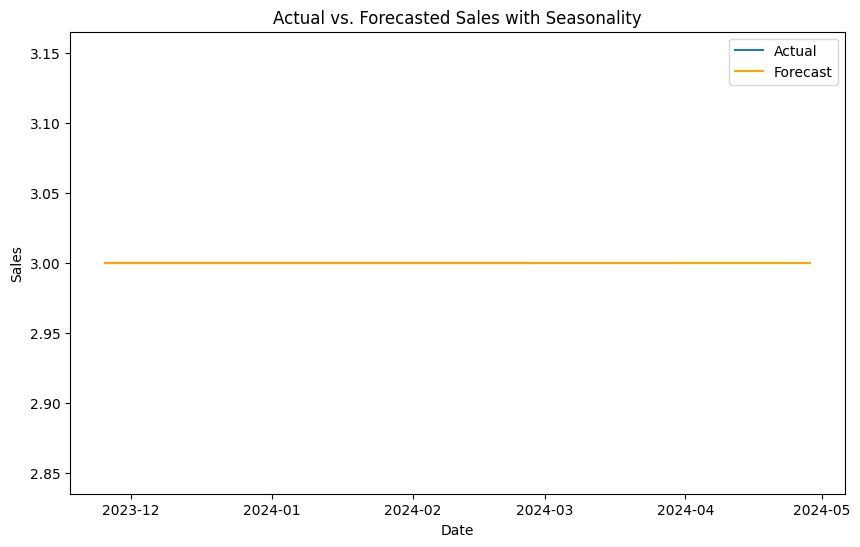

,RegionName,StoreName,BillDate,BillTime,BillNumber,CustomerCode,CustomerName,Quantity,ProductCode,BillSeries,ProductFullName
9,GUJARAT,A-ONE MEDICOS,29/03/2024,9:34PM,SC10426,7278.0,AJAY BHAI THAKKAR,1,14652,SC,VOGLISTATUS 0.3MG TAB 1X10
14,GUJARAT,A-ONE MEDICOS,05/10/2023,10:23PM,SC4718,7278.0,AJAY BHAI THAKKAR,1,14652,SC,VOGLISTATUS 0.3MG TAB 1X10
25,GUJARAT,A-ONE MEDICOS,25/11/2023,7:28PM,SC6008,7278.0,AJAY BHAI THAKKAR,3,14652,SC,VOGLISTATUS 0.3MG TAB 1X10
38,GUJARAT,A-ONE MEDICOS,20/12/2023,10:36PM,SC6839,7278.0,AJAY BHAI THAKKAR,3,14652,SC,VOGLISTATUS 0.3MG TAB 1X10
52,GUJARAT,A-ONE MEDICOS,19/01/2024,9:27PM,SC7980,7278.0,AJAY BHAI THAKKAR,3,14652,SC,VOGLISTATUS 0.3MG TAB 1X10


17:36:38 - cmdstanpy - INFO - Chain [1] start processing
17:36:39 - cmdstanpy - INFO - Chain [1] done processing


Predicted Next Date: 2024-04-28 09:34:00


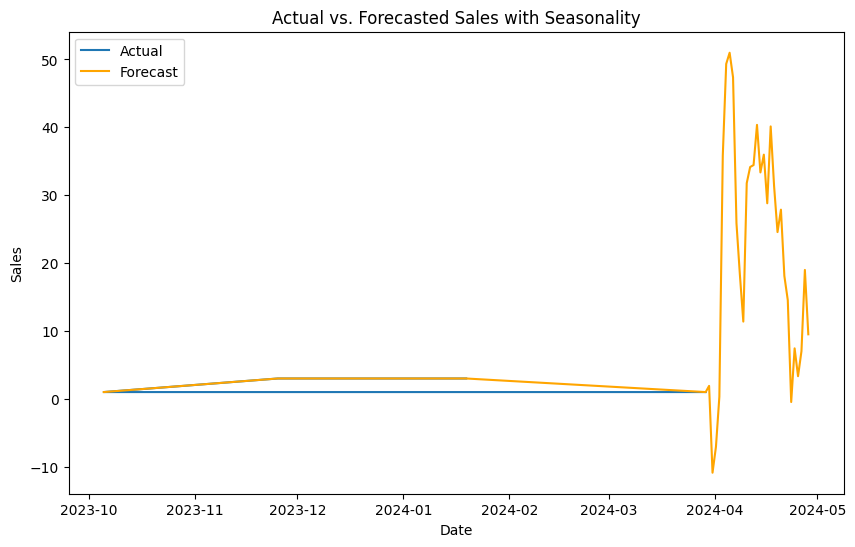

,RegionName,StoreName,BillDate,BillTime,BillNumber,CustomerCode,CustomerName,Quantity,ProductCode,BillSeries,ProductFullName
26,GUJARAT,A-ONE MEDICOS,25/11/2023,7:28PM,SC6008,7278.0,AJAY BHAI THAKKAR,3,18102,SC,DAPLO S 10/100MG TAB 1X10
39,GUJARAT,A-ONE MEDICOS,20/12/2023,10:36PM,SC6839,7278.0,AJAY BHAI THAKKAR,3,18102,SC,DAPLO S 10/100MG TAB 1X10


Predicted Next Date: 2024-01-19 10:36:00


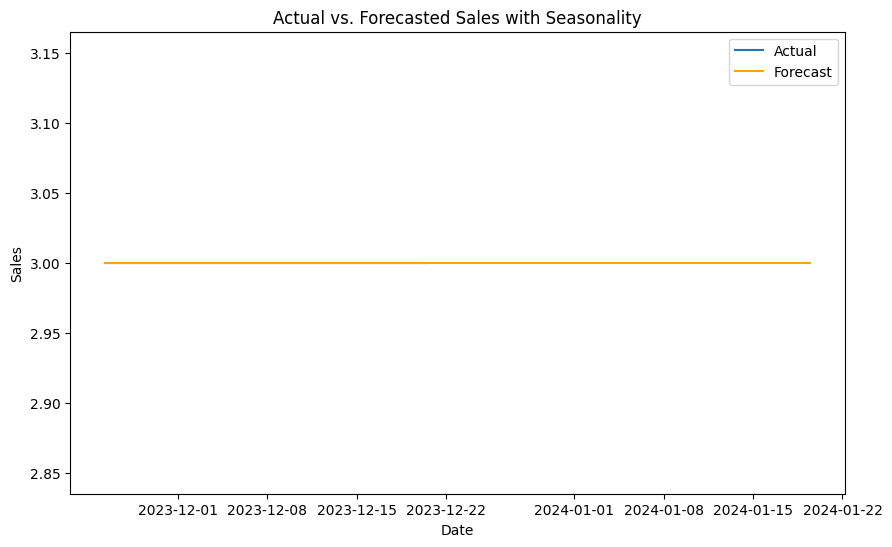

,RegionName,StoreName,BillDate,BillTime,BillNumber,CustomerCode,CustomerName,Quantity,ProductCode,BillSeries,ProductFullName
10,GUJARAT,A-ONE MEDICOS,29/03/2024,9:34PM,SC10426,7278.0,AJAY BHAI THAKKAR,2,18423,SC,ROSUVASTATUS GOLD 20/75/75MG TAB 1X15
27,GUJARAT,A-ONE MEDICOS,25/11/2023,7:28PM,SC6008,7278.0,AJAY BHAI THAKKAR,2,18423,SC,ROSUVASTATUS GOLD 20/75/75MG TAB 1X15
40,GUJARAT,A-ONE MEDICOS,20/12/2023,10:36PM,SC6839,7278.0,AJAY BHAI THAKKAR,2,18423,SC,ROSUVASTATUS GOLD 20/75/75MG TAB 1X15
53,GUJARAT,A-ONE MEDICOS,19/01/2024,9:27PM,SC7980,7278.0,AJAY BHAI THAKKAR,2,18423,SC,ROSUVASTATUS GOLD 20/75/75MG TAB 1X15
65,GUJARAT,A-ONE MEDICOS,26/02/2024,9:28PM,SC9310,7278.0,AJAY BHAI THAKKAR,2,18423,SC,ROSUVASTATUS GOLD 20/75/75MG TAB 1X15


Predicted Next Date: 2024-04-28 09:34:00


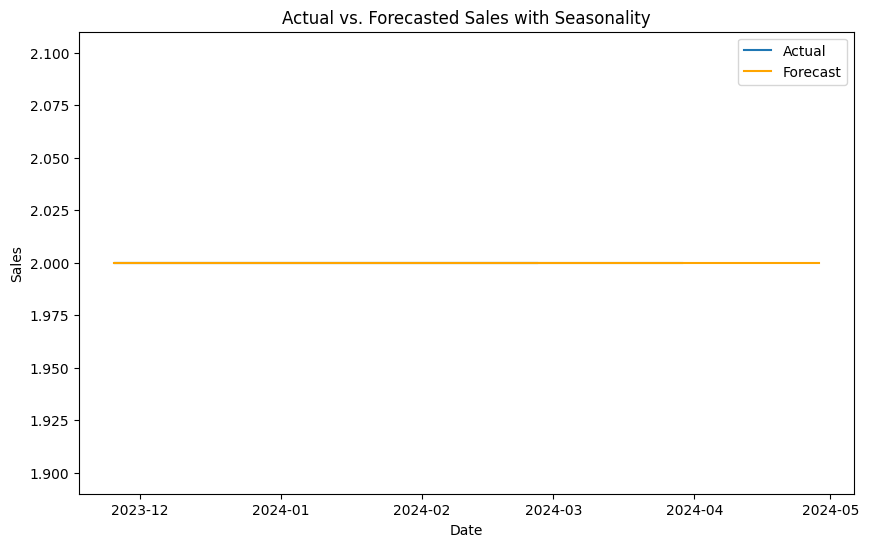

,RegionName,StoreName,BillDate,BillTime,BillNumber,CustomerCode,CustomerName,Quantity,ProductCode,BillSeries,ProductFullName
11,GUJARAT,A-ONE MEDICOS,29/03/2024,9:34PM,SC10426,7278.0,AJAY BHAI THAKKAR,3,19941,SC,SITAMER D 100/10MG TAB 1X10
54,GUJARAT,A-ONE MEDICOS,19/01/2024,9:27PM,SC7980,7278.0,AJAY BHAI THAKKAR,3,19941,SC,SITAMER D 100/10MG TAB 1X10
66,GUJARAT,A-ONE MEDICOS,26/02/2024,9:28PM,SC9310,7278.0,AJAY BHAI THAKKAR,3,19941,SC,SITAMER D 100/10MG TAB 1X10


Predicted Next Date: 2024-04-28 09:34:00


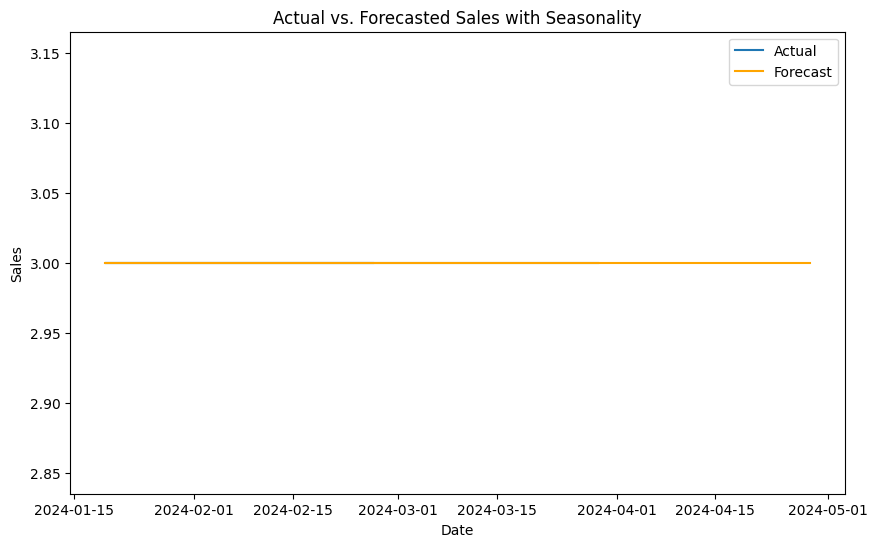

,RegionName,StoreName,BillDate,BillTime,BillNumber,CustomerCode,CustomerName,Quantity,ProductCode,BillSeries,ProductFullName
1,GUJARAT,A-ONE MEDICOS,03/11/2023,7:14PM,SC5502,9210.0,AKASH,7,13087,SC,TELMISTATUS CH 12.5MG TAB 1X10
2,GUJARAT,A-ONE MEDICOS,24/02/2024,3:58PM,SC9238,9210.0,AKASH,10,13087,SC,TELMISTATUS CH 12.5MG TAB 1X10


17:36:40 - cmdstanpy - INFO - Chain [1] start processing
17:36:40 - cmdstanpy - INFO - Chain [1] done processing


Predicted Next Date: 2024-03-25 03:58:00


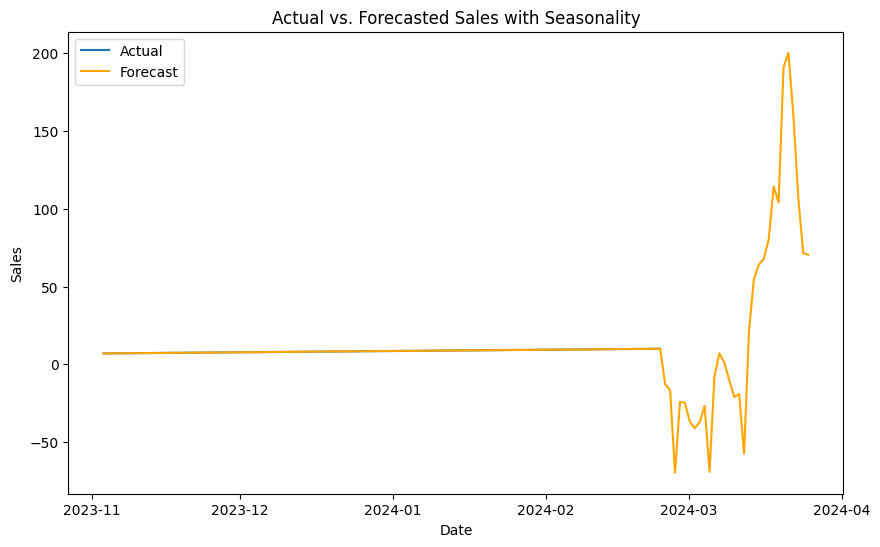

,RegionName,StoreName,BillDate,BillTime,BillNumber,CustomerCode,CustomerName,Quantity,ProductCode,BillSeries,ProductFullName
7,GUJARAT,A-ONE MEDICOS,06/12/2023,7:39PM,SC6367,12366.0,ALPESH C SUTHAR,2,1484,SC,BETNOVATE S CREAM 20GM
13,GUJARAT,A-ONE MEDICOS,16/02/2024,10:02AM,SC8923,12366.0,ALPESH C SUTHAR,1,1484,SC,BETNOVATE S CREAM 20GM


17:36:40 - cmdstanpy - INFO - Chain [1] start processing
17:36:40 - cmdstanpy - INFO - Chain [1] done processing


Predicted Next Date: 2024-03-17 10:02:00


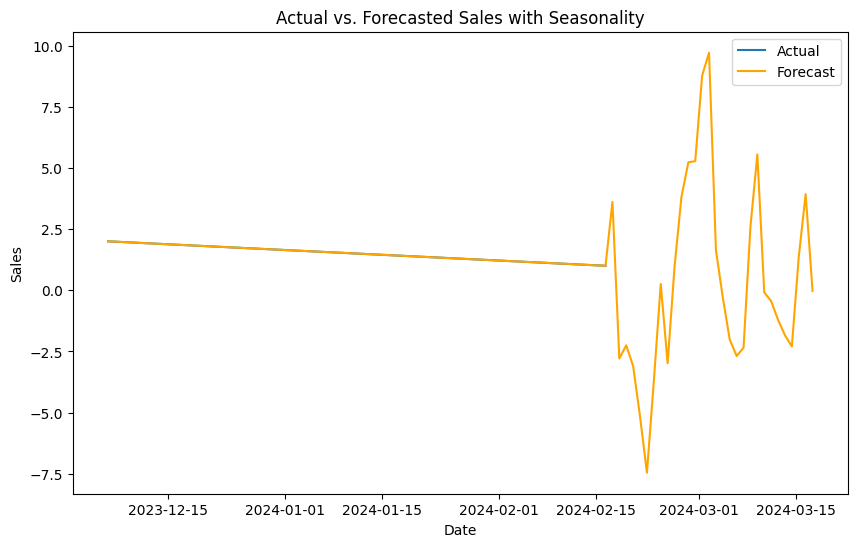

,RegionName,StoreName,BillDate,BillTime,BillNumber,CustomerCode,CustomerName,Quantity,ProductCode,BillSeries,ProductFullName
4,GUJARAT,A-ONE MEDICOS,06/11/2023,7:35PM,SC5597,12366.0,ALPESH C SUTHAR,24,2672,SC,COFSILS COUGH ASSRTD JAR
16,GUJARAT,A-ONE MEDICOS,23/02/2024,7:27PM,SC9207,12366.0,ALPESH C SUTHAR,20,2672,SC,COFSILS COUGH ASSRTD JAR


17:36:40 - cmdstanpy - INFO - Chain [1] start processing
17:36:40 - cmdstanpy - INFO - Chain [1] done processing


Predicted Next Date: 2024-03-24 07:27:00


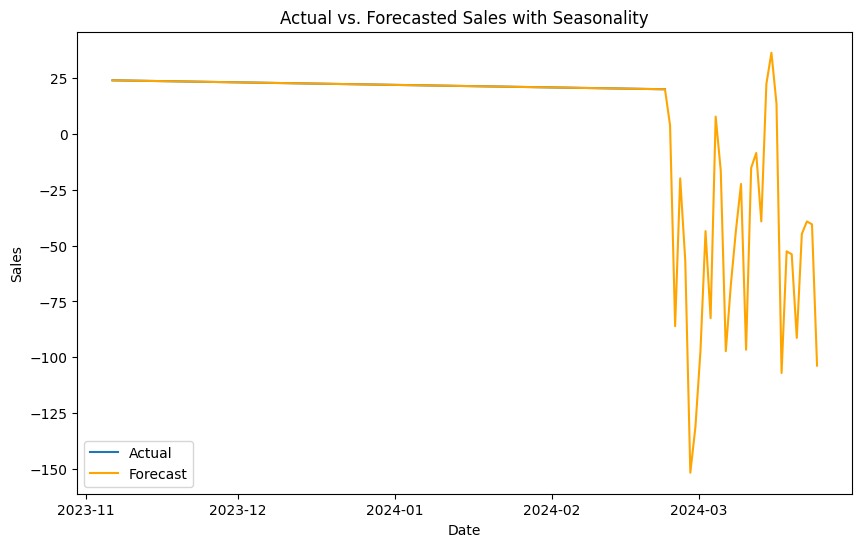

,RegionName,StoreName,BillDate,BillTime,BillNumber,CustomerCode,CustomerName,Quantity,ProductCode,BillSeries,ProductFullName
2,GUJARAT,A-ONE MEDICOS,30/10/2023,9:20PM,SC5365,12366.0,ALPESH C SUTHAR,2,3511,SC,DIOMINIC DCA TAB 1X10
5,GUJARAT,A-ONE MEDICOS,06/11/2023,7:35PM,SC5597,12366.0,ALPESH C SUTHAR,1,3511,SC,DIOMINIC DCA TAB 1X10
8,GUJARAT,A-ONE MEDICOS,31/12/2023,11:44AM,SC7254,12366.0,ALPESH C SUTHAR,1,3511,SC,DIOMINIC DCA TAB 1X10


17:36:41 - cmdstanpy - INFO - Chain [1] start processing
17:36:41 - cmdstanpy - INFO - Chain [1] done processing


Predicted Next Date: 2024-01-30 11:44:00


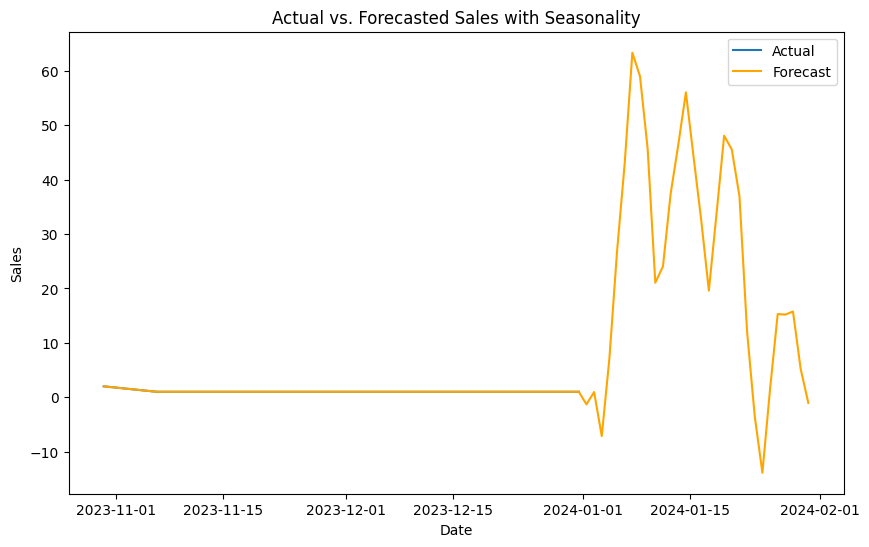

,RegionName,StoreName,BillDate,BillTime,BillNumber,CustomerCode,CustomerName,Quantity,ProductCode,BillSeries,ProductFullName
9,GUJARAT,A-ONE MEDICOS,31/12/2023,11:44AM,SC7254,12366.0,ALPESH C SUTHAR,1,11863,SC,SAFEXIM 200MG TAB 1X10
17,GUJARAT,A-ONE MEDICOS,23/02/2024,7:27PM,SC9207,12366.0,ALPESH C SUTHAR,1,11863,SC,SAFEXIM 200MG TAB 1X10
19,GUJARAT,A-ONE MEDICOS,02/03/2024,4:42PM,SC9493,12366.0,ALPESH C SUTHAR,1,11863,SC,SAFEXIM 200MG TAB 1X10


Predicted Next Date: 2024-04-01 04:42:00


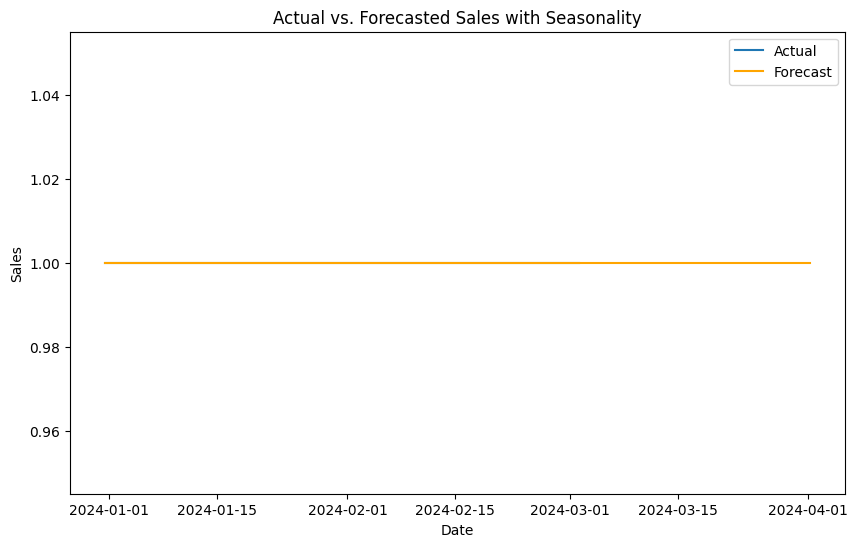

,RegionName,StoreName,BillDate,BillTime,BillNumber,CustomerCode,CustomerName,Quantity,ProductCode,BillSeries,ProductFullName
10,GUJARAT,A-ONE MEDICOS,31/12/2023,11:44AM,SC7254,12366.0,ALPESH C SUTHAR,5,13089,SC,TELMISTATUS H 40/12.5MG TAB 1X10
15,GUJARAT,A-ONE MEDICOS,16/02/2024,10:02AM,SC8923,12366.0,ALPESH C SUTHAR,5,13089,SC,TELMISTATUS H 40/12.5MG TAB 1X10


Predicted Next Date: 2024-03-17 10:02:00


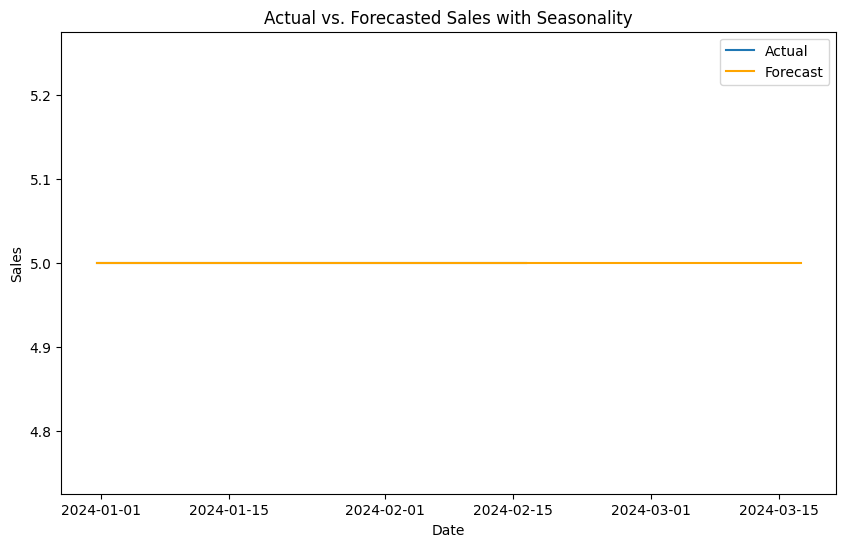

,RegionName,StoreName,BillDate,BillTime,BillNumber,CustomerCode,CustomerName,Quantity,ProductCode,BillSeries,ProductFullName
11,GUJARAT,A-ONE MEDICOS,31/12/2023,11:44AM,SC7254,12366.0,ALPESH C SUTHAR,1,18257,SC,AZIMERIT 250MG TAB 1X6
18,GUJARAT,A-ONE MEDICOS,23/02/2024,7:27PM,SC9207,12366.0,ALPESH C SUTHAR,1,18257,SC,AZIMERIT 250MG TAB 1X6


Predicted Next Date: 2024-03-24 07:27:00


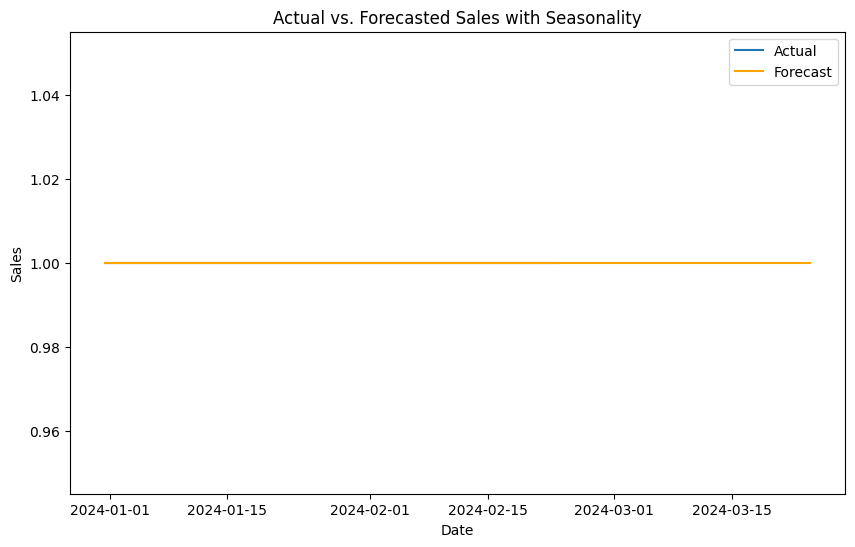

,RegionName,StoreName,BillDate,BillTime,BillNumber,CustomerCode,CustomerName,Quantity,ProductCode,BillSeries,ProductFullName
18,GUJARAT,A-ONE MEDICOS,29/12/2023,10:46AM,SC7155,12881.0,ALPESH SHAH,2,943,SC,ATAZIS 10MG TAB 1X10
20,GUJARAT,A-ONE MEDICOS,11/01/2024,4:46PM,SC7672,12881.0,ALPESH SHAH,1,943,SC,ATAZIS 10MG TAB 1X10


17:36:41 - cmdstanpy - INFO - Chain [1] start processing
17:36:41 - cmdstanpy - INFO - Chain [1] done processing


Predicted Next Date: 2024-02-10 04:46:00


KeyboardInterrupt: 

In [51]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt


def SeasonalityModel(product_purchase):

    # Fit Prophet model with weekly and yearly seasonality
    model = Prophet(seasonality_mode='multiplicative', daily_seasonality=False)
    model.add_seasonality(name='weekly', period=7, fourier_order=3)
    model.add_seasonality(name='monthly', period=30, fourier_order=5)
    model.add_seasonality(name='twomontly', period=60, fourier_order=6)
    model.add_seasonality(name='yearly', period=365.25, fourier_order=10)

    model.fit(product_purchase)

    # Make future date predictions
    future_dates = model.make_future_dataframe(periods=30)
    forecast = model.predict(future_dates)

    # Extract relevant columns from the forecast DataFrame
    forecasted_values = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

    # Extract the prediction for the next date (last row of the forecasted_values DataFrame)
    next_date_prediction = forecasted_values.iloc[-1]['ds']

    print(f"Predicted Next Date: {next_date_prediction}")

    # Plot actual vs. predicted sales
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(product_purchase['ds'], product_purchase['y'], label='Actual')
    ax.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='orange')
    ax.set_xlabel('Date')
    ax.set_ylabel('Sales')
    ax.set_title('Actual vs. Forecasted Sales with Seasonality')
    ax.legend()
    plt.show()


FuncRunModel(SeasonalityModel)

In [40]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

def calculate_metrics(forecast, actual_data):
    """
    Calculate evaluation metrics for Prophet forecast.

    Args:
    - forecast: DataFrame containing forecasted values from Prophet (with columns 'ds' and 'yhat').
    - actual_data: DataFrame containing actual values (with columns 'ds' and 'y').

    Returns:
    - metrics_dict: A dictionary containing calculated evaluation metrics.
    """
    # Merge forecasted values and actual data on 'ds' column
    merged_data = forecast.merge(actual_data, on='ds')

    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(merged_data['y'], merged_data['yhat'])

    # Calculate Root Mean Squared Error (RMSE)
    rmse = root_mean_squared_error(merged_data['y'], merged_data['yhat'])

    # Optionally, calculate other metrics based on your requirements

    # Store metrics in a dictionary
    metrics_dict = {'MAE': mae, 'RMSE': rmse}

    return metrics_dict


In [ ]:
results = {}
n = 0
# Assuming df is your DataFrame containing time series data
for customer_code in CustomerProductPurchase:
    for product_code, product_purchase in CustomerProductPurchase[customer_code].groupby('ProductCode'):
        # select product greater than 2
        if len(product_purchase) < 2:
            continue
        product_purchase['bill_datetime'] = pd.to_datetime(product_purchase['BillDate'] + " " + product_purchase['BillTime'], format='%d/%m/%Y %H:%M%p')
        # getting ready for model
        product_purchase.rename(columns={'bill_datetime': 'ds', 'Quantity': 'y'}, inplace=True)


        # Define a range of Fourier orders to test
        Fourier_orders = [2, 3, 4, 5]

        # Initialize an empty dictionary to store results
        train_data = product_purchase[:-1]  # Use all data except the last 30 days for training
        val_data = product_purchase[-1:]    # Use the last 30 days for validation

        if len(train_data) < 2:
            continue

        for order in range(2, 12):
            # Create a Prophet model with the current Fourier order
            model = Prophet(yearly_seasonality=order)

            # Fit the model to the training data
            model.fit(train_data)

            # Make predictions for the validation period
            forecast = model.predict(val_data)

            # Calculate evaluation metrics (e.g., MAE, RMSE) and store results
            prev = results.get(order, {'MAE': 0, 'RMSE': 0})
            next = calculate_metrics(forecast, val_data)
            results[order] = {'MAE': prev['MAE'] + next['MAE'], 'RMSE': prev['RMSE'] + next['RMSE']}

        n += 1
print(results)        

## ARIMA Model 

In [56]:
#next_purchase_date = forecast.loc[forecast['ds'] == forecast['ds'].max(), 'ds'].values[0]
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Load your time series data into a DataFrame (assuming df is your DataFrame)
# Preprocess data as needed (e.g., set datetime index, handle missing values)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Sample data (replace this with your actual dataset)
data = {
    'time': pd.date_range('2022-01-01', periods=100),
    'quantity': np.random.randint(50, 200, 100),
    'sales': np.random.randint(1000, 5000, 100)
}
df = pd.DataFrame(data)

# Convert time to numeric values for regression (optional)
df['time_numeric'] = pd.to_numeric(df['time'])

# Perform linear regression
X = df[['time_numeric', 'quantity']]
y = df['sales']
model = LinearRegression().fit(X, y)

# Generate predicted sales values
df['predicted_sales'] = model.predict(X)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(df['time'], df['sales'], label='Actual Sales')
plt.plot(df['time'], df['predicted_sales'], color='red', label='Predicted Sales')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.title('Simple Linear Regression: Time vs. Sales')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [1]:
from sklearn.model_selection import train_test_split

# Assuming df is your DataFrame with columns 'ds' and 'y'
X = df[['ds']]  # Features (independent variables)
y = df['y']

# Split the data into training and testing sets (e.g., 80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


# Extract actual and predicted values
actual_values = test_data['y'].values
predicted_values = forecast['yhat'].values[-len(test_data):]

ModuleNotFoundError: No module named 'sklearn'